In [1]:
!python --version


Python 3.13.0


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (classification_report, confusion_matrix, 
                             accuracy_score, precision_score, recall_score, 
                             f1_score, roc_auc_score, roc_curve)
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import joblib
import warnings
warnings.filterwarnings('ignore')

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)




business problem

In [14]:

print("BUSINESS PROBLEM: Predicting High Income Earners")


print("""
PROBLEM STATEMENT:
Predict whether an individual earns more than $50K per year based on 
demographic and employment census data from the 1994 US Census.

PRIMARY USE CASE:
Financial institutions targeting individuals for premium credit card offers
(annual fee: $495, minimum income requirement typically $50K+).

BUSINESS VALUE:
1. Optimize Marketing ROI:
   - Reduce wasted marketing spend on unqualified leads
   - Focus premium product offers on appropriate income segments
   
2. Customer Experience:
   - Avoid offering products to individuals who don't meet income requirements
   - Prevent application rejections that harm brand perception
   
3. Risk Management:
   - Ensure credit products are offered to customers with appropriate income levels
   - Reduce potential default risk from underqualified applicants

COST-BENEFIT ANALYSIS:
- Cost of False Positive (predict >50K, actually ≤50K):
  * $25 marketing cost per person
  * Negative brand perception from rejection
  * Potential compliance issues
  
- Cost of False Negative (predict ≤50K, actually >50K):
  * Missed revenue opportunity (~$150/year in fees + interest)
  * Competitor acquisition risk
  
- Conclusion: FP and FN costs are significant, but FP has immediate 
  tangible costs + reputational damage.

EVALUATION METRIC SELECTION:
Primary: F1-SCORE
- Balances precision (avoid wasting marketing budget on wrong targets)
  and recall (capture enough high earners for ROI)
  
Secondary: PRECISION
- Monitor to ensure we don't over-target low-income individuals
- Target: Precision ≥ 0.75 (3 out of 4 targeted are actually >50K)

Secondary: RECALL  
- Ensure we capture sufficient market opportunity
- Target: Recall ≥ 0.70 (capture 70% of high earners)

BASELINE EXPECTATION:
- Census data shows ~24% earn >50K (class imbalance)
- Random classifier: ~50% accuracy, F1 ~0.39
- Target: F1-score ≥ 0.65, significantly beating baseline
""")



BUSINESS PROBLEM: Predicting High Income Earners

PROBLEM STATEMENT:
Predict whether an individual earns more than $50K per year based on 
demographic and employment census data from the 1994 US Census.

PRIMARY USE CASE:
Financial institutions targeting individuals for premium credit card offers
(annual fee: $495, minimum income requirement typically $50K+).

BUSINESS VALUE:
1. Optimize Marketing ROI:
   - Reduce wasted marketing spend on unqualified leads
   - Focus premium product offers on appropriate income segments

2. Customer Experience:
   - Avoid offering products to individuals who don't meet income requirements
   - Prevent application rejections that harm brand perception

3. Risk Management:
   - Ensure credit products are offered to customers with appropriate income levels
   - Reduce potential default risk from underqualified applicants

COST-BENEFIT ANALYSIS:
- Cost of False Positive (predict >50K, actually ≤50K):
  * $25 marketing cost per person
  * Negative brand pe

In [15]:
# Data Loading and Initial Exploration

# Define column names as a list since adult.csv has no header row
column_names = [
    'age', 'workclass', 'fnlwgt', 'education', 'education_num',
    'marital_status', 'occupation', 'relationship', 'race', 'sex',
    'capital_gain', 'capital_loss', 'hours_per_week', 'native_country', 'income'
]

# Load CSV file into pandas DataFrame
# names=column_names: Assign custom column names to the dataframe
# skipinitialspace=True: Remove leading spaces after delimiters (adult.csv has spaces after commas)
# na_values='?': Treat '?' characters as missing values (NaN)
df = pd.read_csv('adult.csv', names=column_names, 
                 skipinitialspace=True, na_values='?')

# Display the dimensions of the dataset (rows, columns)
print("Dataset Shape:", df.shape)
# Format row count with comma separators and show feature count
print(f"Total samples: {df.shape[0]:,}, Features: {df.shape[1]}")

# Display the first 5 rows to visually inspect the data structure
print("\nFirst 5 Rows:")
print(df.head())

# Check data type of each column (int64, float64, object/string)
print("\nData Types:")
print(df.dtypes)
# Count how many columns are numerical (integers or floats)
print(f"\nNumerical columns: {df.select_dtypes(include=['int64', 'float64']).shape[1]}")
# Count how many columns are categorical (object type = strings)
print(f"Categorical columns: {df.select_dtypes(include='object').shape[1]}")

# Check for missing values (NaN) in each column
print("\nMissing Values:")
# Sum null values per column and store in 'missing' variable
missing = df.isnull().sum()
# Display only columns that have missing values (where count > 0)
print(missing[missing > 0])
# If any missing values exist in the entire dataset
if missing.sum() > 0:
    # Calculate total missing values and percentage of entire dataset
    print(f"\nTotal missing: {missing.sum()} ({missing.sum()/len(df)*100:.2f}%)")
    # Provide context about which columns have missing data
    print("Note: Missing values primarily in workclass, occupation, native_country")
    # Document planned handling strategy for later preprocessing
    print("Strategy: Will impute with mode or create 'Unknown' category")

# Generate statistical summary for numerical columns (mean, std, min, quartiles, max)
print("\nBasic Statistics (Numerical Features):")
print(df.describe())

# Analyze the target variable distribution
print("\nTarget Variable Distribution:")
# Count occurrences of each income category (≤50K and >50K)
print(df['income'].value_counts())
# Show proportions (percentages) instead of raw counts
print(df['income'].value_counts(normalize=True))
# Document the class imbalance observation
print("\nClass Imbalance Detected: ~3:1 ratio (≤50K : >50K)")

# Check for duplicate rows in the entire dataset
print("\nDuplicate Check:")
# Count how many rows are exact duplicates of previous rows
duplicates = df.duplicated().sum()
# Display count and percentage of duplicates
print(f"Duplicates found: {duplicates} ({duplicates/len(df)*100:.2f}%)")

# Analyze categorical feature complexity (number of unique categories)
print("\nCategorical Feature Complexity:")
# Get list of all categorical column names (object dtype)
categorical_cols = df.select_dtypes(include='object').columns
# Loop through each categorical column
for col in categorical_cols:
    # Count unique values (cardinality) in this column
    unique_count = df[col].nunique()
    # Print column name and its cardinality
    print(f"  {col}: {unique_count} unique values")

# Document key findings and implications for preprocessing
print("\nInitial Observations:")
print("1. fnlwgt appears to be a census weight - likely not useful for prediction")
print("2. education and education_num are redundant - will keep education_num")
print("3. Class imbalance requires stratified sampling and appropriate metrics")
print("4. Missing values in workclass/occupation need careful handling")


Dataset Shape: (48843, 15)
Total samples: 48,843, Features: 15

First 5 Rows:
   age  workclass  fnlwgt     education    education_num      marital_status  \
0  age  workclass  fnlwgt     education  educational-num      marital-status   
1   25    Private  226802          11th                7       Never-married   
2   38    Private   89814       HS-grad                9  Married-civ-spouse   
3   28  Local-gov  336951    Assoc-acdm               12  Married-civ-spouse   
4   44    Private  160323  Some-college               10  Married-civ-spouse   

          occupation  relationship   race     sex  capital_gain  capital_loss  \
0         occupation  relationship   race  gender  capital-gain  capital-loss   
1  Machine-op-inspct     Own-child  Black    Male             0             0   
2    Farming-fishing       Husband  White    Male             0             0   
3    Protective-serv       Husband  White    Male             0             0   
4  Machine-op-inspct       Husband  

In [16]:
print("DATA CLEANING")

# Fix income column - remove inconsistent formatting
print(f"Before cleaning - Unique values: {df['income'].unique()}")
print(f"Before cleaning - Shape: {df.shape}")

# Remove periods from income labels ('>50K.' becomes '>50K')
# Strip whitespace to ensure consistent matching
df['income'] = df['income'].str.replace('.', '', regex=False).str.strip()

# Filter to only valid income categories (removes any malformed rows)
df = df[df['income'].isin(['<=50K', '>50K'])].copy()

print(f"\nAfter cleaning - Unique values: {df['income'].unique()}")
print(f"After cleaning - Shape: {df.shape}")
print(f"Value counts:\n{df['income'].value_counts()}")

# Remove duplicate rows identified in EDA
print(f"\nBefore removing duplicates: {df.shape}")
df = df.drop_duplicates()
print(f"After removing duplicates: {df.shape}")

# Drop fnlwgt column (census sampling weight - not a useful predictor)
print(f"\nDropping fnlwgt column...")
df = df.drop('fnlwgt', axis=1)
print(f"Columns remaining: {df.shape[1]}")

# Convert numeric columns to proper data types
print("\nConverting numeric columns to proper data types")

# Define columns that should be numeric (excluding fnlwgt which we dropped)
numeric_cols = ['age', 'education_num', 'capital_gain', 
                'capital_loss', 'hours_per_week']

# Convert each column to numeric, coercing errors to NaN
for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

print(f"Data types after conversion:")
print(df[numeric_cols].dtypes)

# Check if any values couldn't be converted (became NaN)
nan_counts = df[numeric_cols].isnull().sum()
if nan_counts.sum() > 0:
    print(f"\nMissing values created by conversion:")
    print(nan_counts[nan_counts > 0])
    # Drop rows with invalid numeric values
    df = df.dropna(subset=numeric_cols)
    print(f"Rows dropped: {nan_counts.sum()}")
    print(f"New shape: {df.shape}")
else:
    print("\nNo invalid numeric values detected - all conversions successful")

# Handle missing values in categorical columns
print("\nHandling missing values in categorical columns:")
categorical_cols = ['workclass', 'occupation', 'native_country']

for col in categorical_cols:
    missing_count = df[col].isnull().sum()
    if missing_count > 0:
        # Replace missing values with 'Unknown' category
        df[col] = df[col].fillna('Unknown')
        print(f"  {col}: {missing_count} missing values filled with 'Unknown'")

# Verify no missing values remain
print(f"\nFinal missing value check:")
remaining_missing = df.isnull().sum().sum()
print(f"Total missing values: {remaining_missing}")

print(f"\nFinal dataset shape: {df.shape}")
print("Data cleaning complete")


DATA CLEANING
Before cleaning - Unique values: ['income' '<=50K' '>50K']
Before cleaning - Shape: (48843, 15)

After cleaning - Unique values: ['<=50K' '>50K']
After cleaning - Shape: (48842, 15)
Value counts:
income
<=50K    37155
>50K     11687
Name: count, dtype: int64

Before removing duplicates: (48842, 15)
After removing duplicates: (48790, 15)

Dropping fnlwgt column...
Columns remaining: 14

Converting numeric columns to proper data types
Data types after conversion:
age               int64
education_num     int64
capital_gain      int64
capital_loss      int64
hours_per_week    int64
dtype: object

No invalid numeric values detected - all conversions successful

Handling missing values in categorical columns:
  workclass: 2795 missing values filled with 'Unknown'
  occupation: 2805 missing values filled with 'Unknown'
  native_country: 856 missing values filled with 'Unknown'

Final missing value check:
Total missing values: 0

Final dataset shape: (48790, 14)
Data cleaning co

EXPLORATORY DATA ANALYSIS

Target variable distribution:
income
<=50K    37109
>50K     11681
Name: count, dtype: int64

Class Imbalance Ratio: 0.31


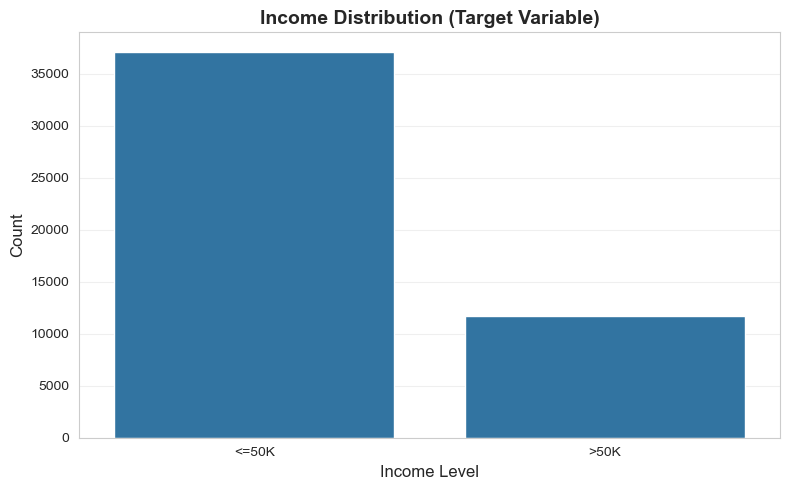


Target variable insight:
- Significant class imbalance: ~76% earn <=50K, ~24% earn >50K
- This imbalance requires careful metric selection (cannot rely on accuracy alone)
- Will use stratified sampling to preserve this ratio in train/test split


Numeric Features vs Income:


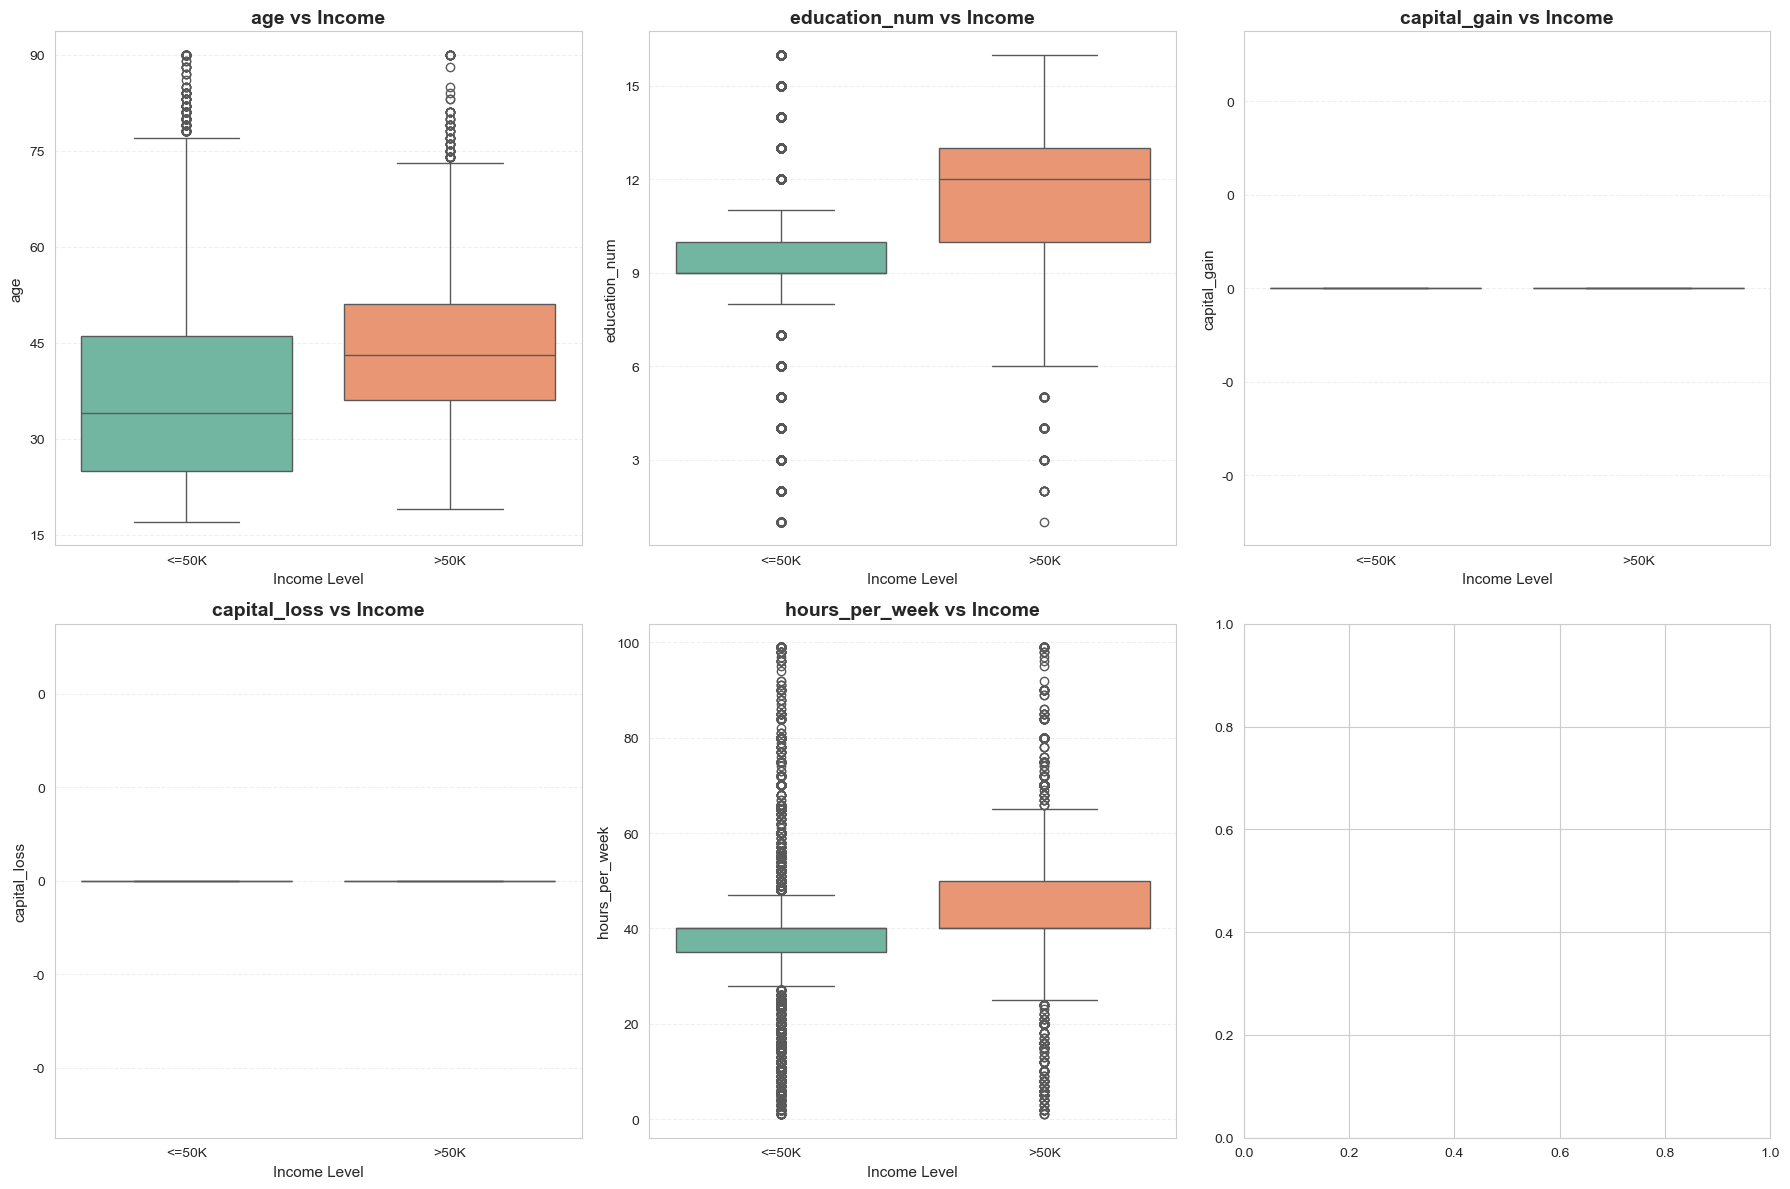


Capital gain/loss: Detailed analysis (excluding zeros)

Percentage with capital_gain > 0: 8.3%
Percentage with capital_loss > 0: 4.7%


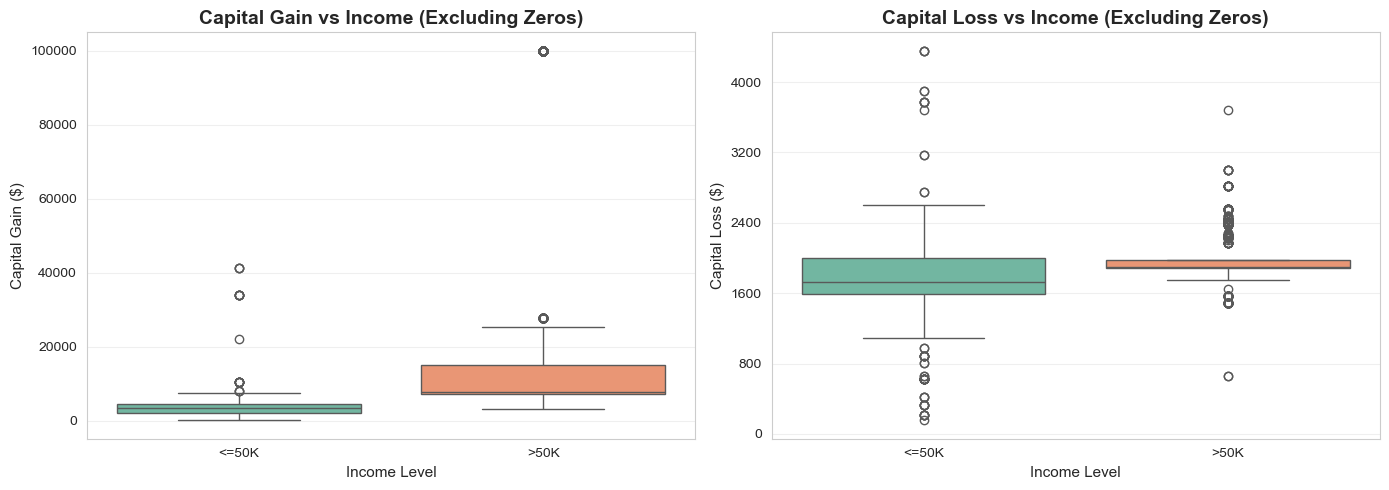


Capital gain/loss insights:
- Most people (~91%) have ZERO capital gain
- Most people (~95%) have ZERO capital loss
- Among those with capital gains, high earners have significantly higher amounts
- This is a strong signal: capital investments separate income classes
- Recommendation: Create binary features 'has_capital_gain' and 'has_capital_loss'


Numeric features statistics by income group:
       Feature  Mean (<=50K)  Mean (>50K)  Median (<=50K)  Median (>50K)  Mean Difference  % Increase
           age     36.882751    44.276004            34.0           43.0         7.393253        20.0
 education_num      9.598938    11.603287             9.0           12.0         2.004349        20.9
  capital_gain    147.192541  4044.315812             0.0            0.0      3897.123271      2647.6
  capital_loss     54.219057   193.628371             0.0            0.0       139.409313       257.1
hours_per_week     38.842976    45.454584            40.0           40.0         6.611608  

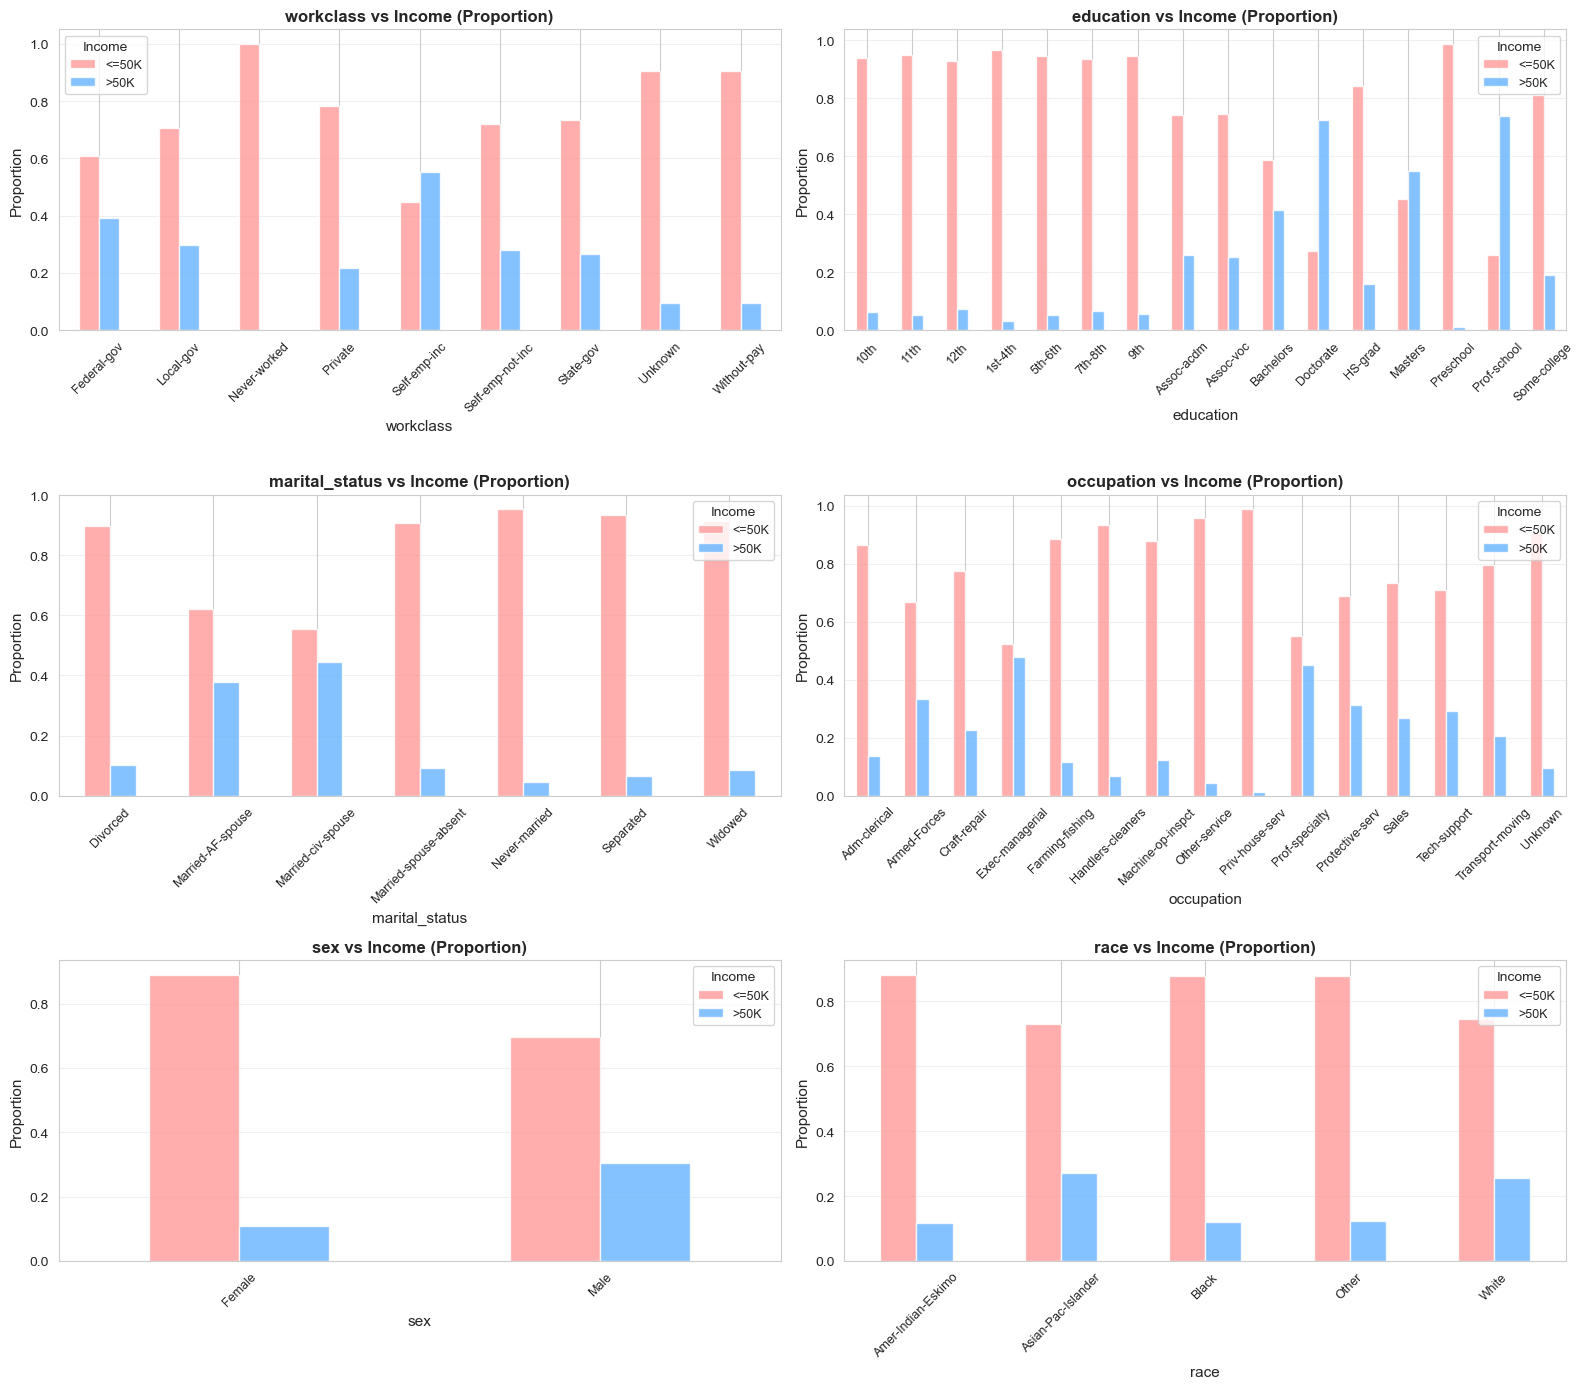


Categorical features insights:
- Education: Higher degrees (Bachelors, Masters, Doctorate) strongly predict >50K
  → Prof-school and Doctorate have >70% earning >50K
- Marital Status: Married-civ-spouse has highest >50K rate (~45%)
  → Singles/Never-married have very low >50K rate (~10%)
- Occupation: Exec-managerial and Prof-specialty have highest >50K rates
  → Service jobs (Handlers-cleaners, Other-service) have lowest rates
- Sex: Males have significantly higher >50K rate (~31% vs ~11% for females)
  → Potential fairness/bias concern for deployment
- Workclass: Self-employed and Federal-gov workers earn more on average
- Race: Asian-Pac-Islander and White have higher >50K rates

Feature Engineering Ideas:
- Create binary 'is_married' feature (married vs not)
- Create 'high_education' flag (Bachelors+ = 1, else = 0)
- Create 'has_capital_gain' and 'has_capital_loss' binary flags
- Group rare occupation/workclass categories into 'Other'


Native Country Analysis:
Unique countries: 4

<Figure size 1200x600 with 0 Axes>

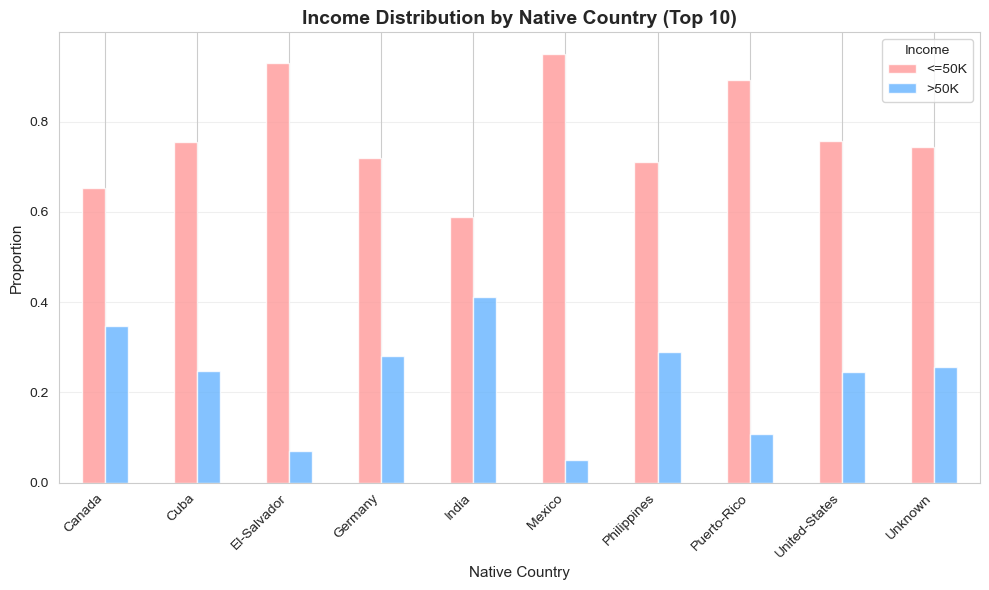


Native Country Insights:
- Dataset is heavily dominated by United-States (~90%)
- Many countries have very few samples (<50), making them unreliable for predictions
- Recommendation: Group rare countries (count <50) into 'Other' category
- This will reduce dimensionality and prevent overfitting to rare categories


One hot encoding categorical features for correlation analysis
Original features: 14
After one-hot encoding: 57
New dummy variables created: 43

Correlation analysis with target:

Top 15 features most correlated with income (>50K):
income_encoded                       1.000000
marital_status_Married-civ-spouse    0.445663
education_num                        0.332802
age                                  0.230144
hours_per_week                       0.227664
capital_gain                         0.223047
sex_Male                             0.214639
occupation_Exec-managerial           0.210818
occupation_Prof-specialty            0.188799
education_Bachelors                 

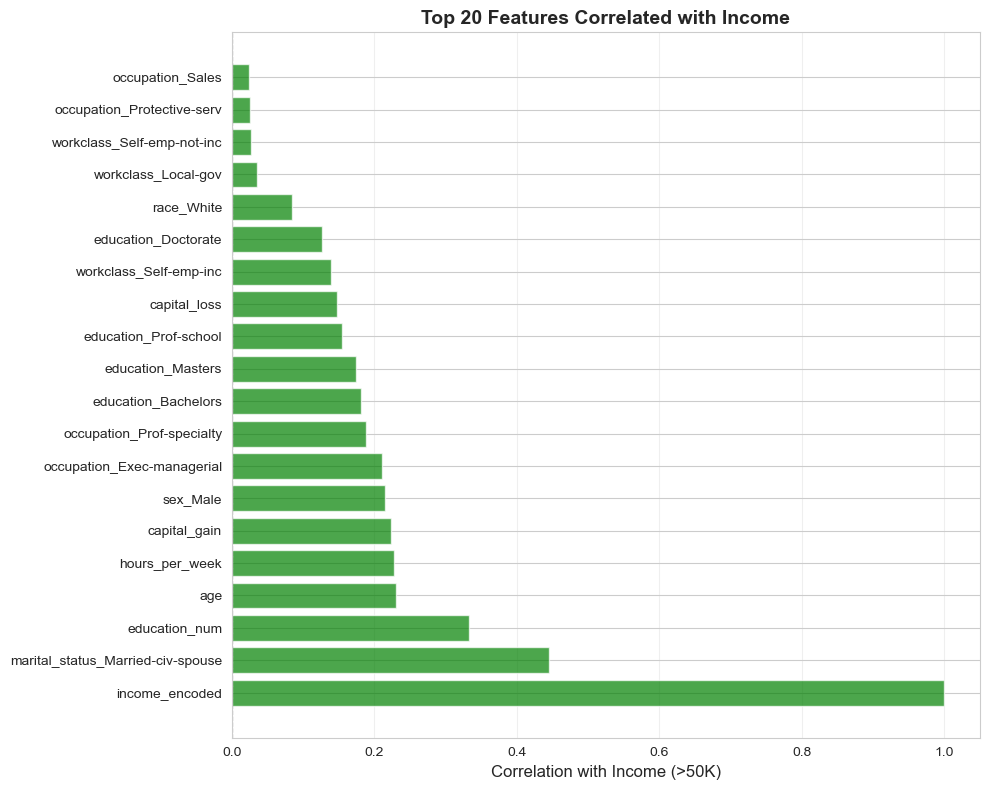


Correlation insights:
Strongest Positive Predictors (>0.3 correlation):
- marital_status = Married-civ-spouse (~+0.40 to +0.45)
- education_num (+0.33 to +0.34)
- capital_gain (+0.22)
- age (+0.23)
- occupation = Exec-managerial or Prof-specialty (+0.18 to +0.20)

Strongest Negative Predictors:
- marital_status = Never-married (~-0.26)
- relationship = Own-child (~-0.23)
- occupation = Other-service or Handlers-cleaners (~-0.15)
- education levels: HS-grad, Some-college (negative)

Key Takeaways:
- Marital status is the strongest single categorical predictor
- Education (both numeric and categorical) is critical
- Capital investments strongly separate high/low earners
- Occupation type matters significantly
- Age has moderate positive correlation


Correlation Heatmap


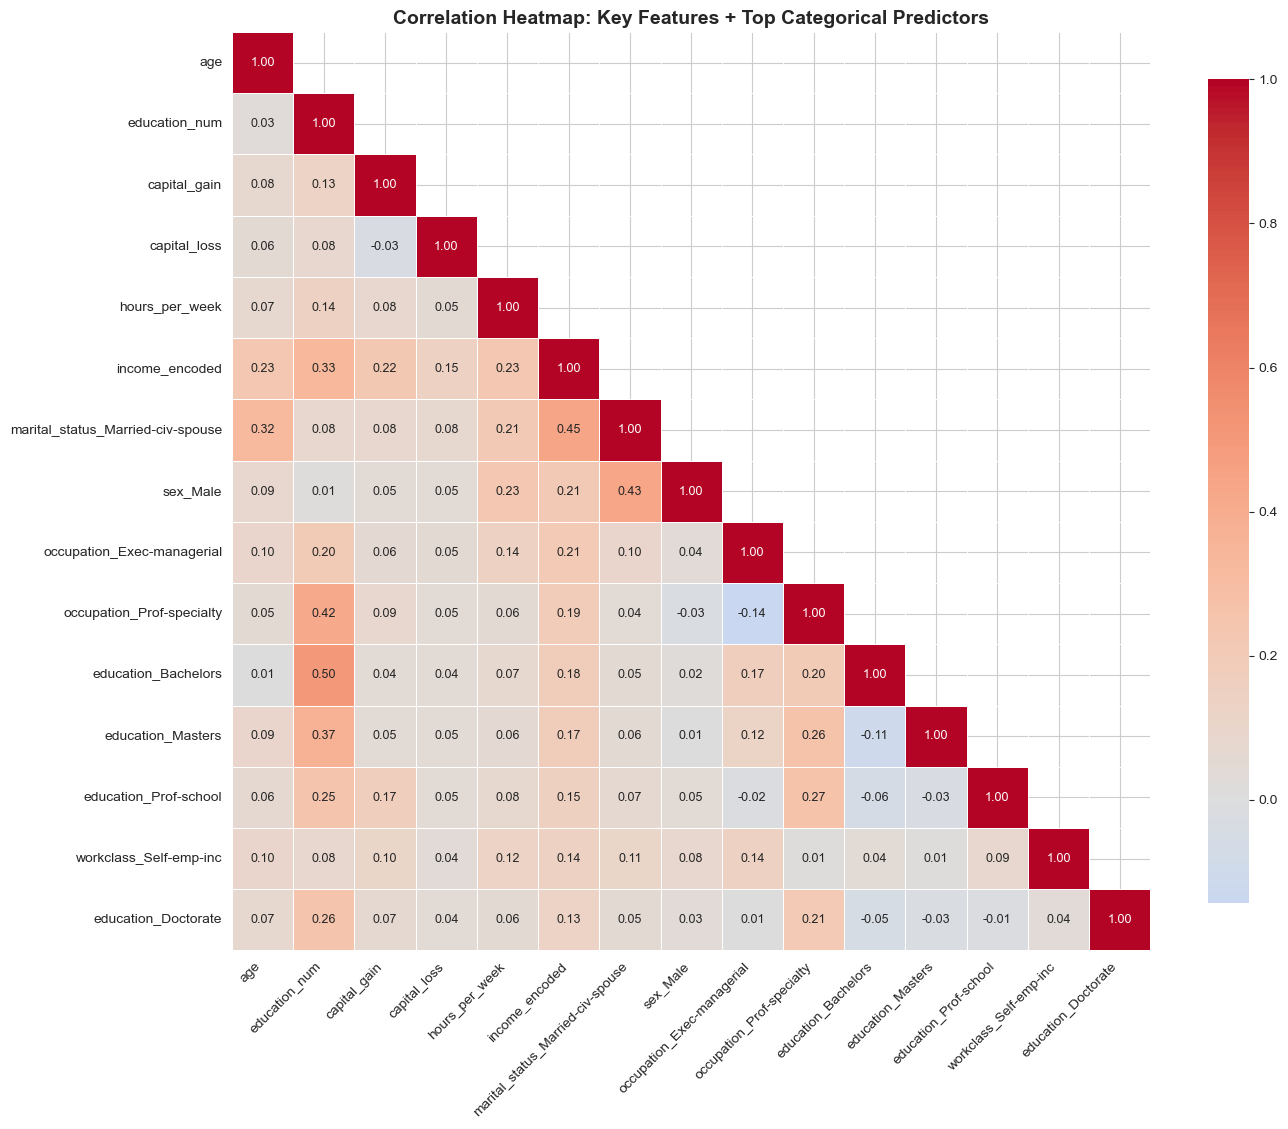


Multicollinearity Check:
- education (categorical) and education_num are highly correlated
  → Will use education_num only (numeric is easier for models)
- marital_status categories are mutually exclusive by design (expected)
- relationship and marital_status show some correlation (logical)
- No concerning multicollinearity between predictive features
- All features can be safely used in modeling


Skewness Analysis
capital_gain      11.888265
capital_loss       4.567037
age                0.556582
hours_per_week     0.239652
education_num     -0.314229
dtype: float64


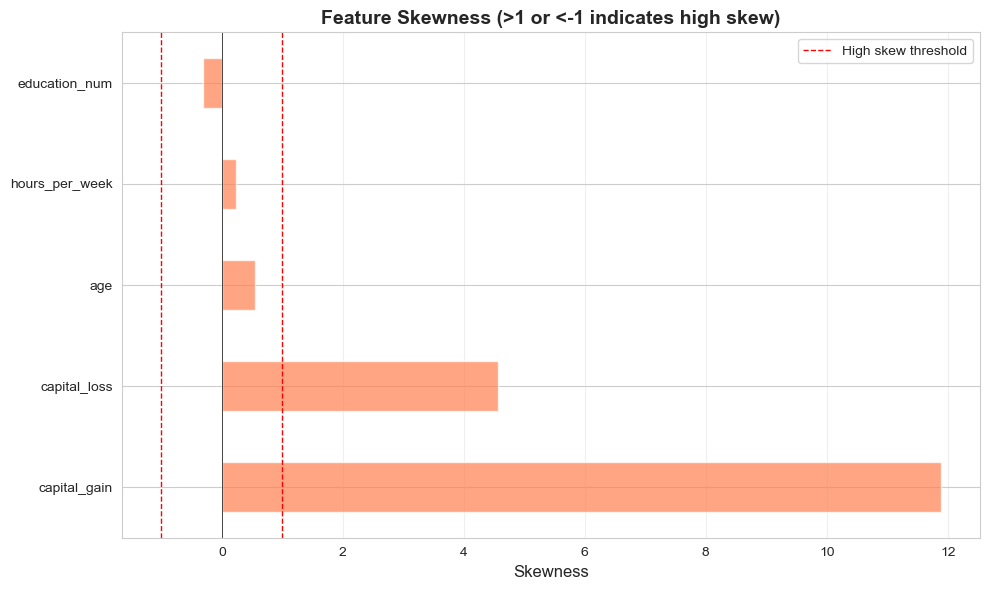


Skewness insights & recommendations:
- capital_gain (skew > 10): Extremely right-skewed due to many zeros
  → Recommendation: Create binary flag 'has_capital_gain' OR use log(x+1) transform

- capital_loss (skew > 4): Highly right-skewed due to many zeros
  → Recommendation: Create binary flag 'has_capital_loss' OR use log(x+1) transform

- age, education_num, hours_per_week: Relatively normal (skew < 1)
  → Recommendation: StandardScaler only, no transformation needed

For our model, we'll create binary flags for capital features to handle the extreme skew.


INITIAL FEATURE ASSESSMENT

FEATURES LIKELY TO BE USEFUL:

Based on EDA analysis, the following features show strong predictive power:

Numeric Features:
• age - Moderate positive correlation (+0.23), clear separation between income groups
• education_num - Strong predictor (+0.33), high earners have ~30% more education
• capital_gain - Strong signal (+0.22), massive difference between income groups
• capital_loss - Moderate pre

In [17]:
print("EXPLORATORY DATA ANALYSIS")

# Define numeric columns (fnlwgt was dropped in data cleaning)
numeric_cols = ['age', 'education_num', 'capital_gain', 
                'capital_loss', 'hours_per_week']

# Target variable distribution
print("\nTarget variable distribution:")
target_counts = df['income'].value_counts()
print(target_counts)
print(f"\nClass Imbalance Ratio: {target_counts.min() / target_counts.max():.2f}")

plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='income', order=['<=50K', '>50K'])
plt.title('Income Distribution (Target Variable)', fontsize=14, fontweight='bold')
plt.ylabel('Count', fontsize=12)
plt.xlabel('Income Level', fontsize=12)
plt.xticks(rotation=0)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

print("""\nTarget variable insight:
- Significant class imbalance: ~76% earn <=50K, ~24% earn >50K
- This imbalance requires careful metric selection (cannot rely on accuracy alone)
- Will use stratified sampling to preserve this ratio in train/test split
""")

# Numeric feature analysis
print("\nNumeric Features vs Income:")

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.ravel()

for idx, col in enumerate(numeric_cols):
    # Create boxplot with outliers hidden for capital features
    if col in ['capital_gain', 'capital_loss']:
        sns.boxplot(data=df, x='income', y=col, ax=axes[idx], 
                   palette='Set2', showfliers=False, order=['<=50K', '>50K'])
    else:
        sns.boxplot(data=df, x='income', y=col, ax=axes[idx], 
                   palette='Set2', order=['<=50K', '>50K'])
    
    axes[idx].set_title(f'{col} vs Income', fontsize=14, fontweight='bold')
    axes[idx].set_xlabel('Income Level', fontsize=11)
    axes[idx].set_ylabel(col, fontsize=11)
    
    # Reduce number of y-axis ticks to prevent overlap
    axes[idx].yaxis.set_major_locator(plt.MaxNLocator(nbins=6))
    
    # Format capital features with K suffix (removed fnlwgt)
    if col in ['capital_gain', 'capital_loss']:
        from matplotlib.ticker import FuncFormatter
        def thousands_formatter(x, pos):
            if abs(x) >= 1000:
                return f'{x/1000:.0f}K'
            return f'{x:.0f}'
        axes[idx].yaxis.set_major_formatter(FuncFormatter(thousands_formatter))
    
    # Add grid for readability
    axes[idx].grid(axis='y', alpha=0.3, linestyle='--')
    
    # Rotate x-axis labels
    axes[idx].tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.show()

# Capital gain/loss detailed analysis
print("\nCapital gain/loss: Detailed analysis (excluding zeros)")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Capital gain (non-zero only)
df_with_gain = df[df['capital_gain'] > 0]
print(f"\nPercentage with capital_gain > 0: {len(df_with_gain)/len(df)*100:.1f}%")
if len(df_with_gain) > 0:
    sns.boxplot(data=df_with_gain, x='income', y='capital_gain', ax=axes[0], 
               palette='Set2', order=['<=50K', '>50K'])
    axes[0].set_title('Capital Gain vs Income (Excluding Zeros)', fontsize=14, fontweight='bold')
    axes[0].set_ylabel('Capital Gain ($)', fontsize=11)
    axes[0].set_xlabel('Income Level', fontsize=11)
    axes[0].grid(axis='y', alpha=0.3)
    axes[0].yaxis.set_major_locator(plt.MaxNLocator(nbins=6))
else:
    axes[0].text(0.5, 0.5, 'No data with capital gain > 0', 
                ha='center', va='center', transform=axes[0].transAxes)

# Capital loss (non-zero only)
df_with_loss = df[df['capital_loss'] > 0]
print(f"Percentage with capital_loss > 0: {len(df_with_loss)/len(df)*100:.1f}%")
if len(df_with_loss) > 0:
    sns.boxplot(data=df_with_loss, x='income', y='capital_loss', ax=axes[1], 
               palette='Set2', order=['<=50K', '>50K'])
    axes[1].set_title('Capital Loss vs Income (Excluding Zeros)', fontsize=14, fontweight='bold')
    axes[1].set_ylabel('Capital Loss ($)', fontsize=11)
    axes[1].set_xlabel('Income Level', fontsize=11)
    axes[1].grid(axis='y', alpha=0.3)
    axes[1].yaxis.set_major_locator(plt.MaxNLocator(nbins=6))
else:
    axes[1].text(0.5, 0.5, 'No data with capital loss > 0', 
                ha='center', va='center', transform=axes[1].transAxes)

plt.tight_layout()
plt.show()

print("""\nCapital gain/loss insights:
- Most people (~91%) have ZERO capital gain
- Most people (~95%) have ZERO capital loss
- Among those with capital gains, high earners have significantly higher amounts
- This is a strong signal: capital investments separate income classes
- Recommendation: Create binary features 'has_capital_gain' and 'has_capital_loss'
""")

print("\nNumeric features statistics by income group:")

# Create separate dataframes for each income group 
low_income = df[df['income'] == '<=50K'][numeric_cols]
high_income = df[df['income'] == '>50K'][numeric_cols]

comparison = pd.DataFrame({
    'Feature': numeric_cols,
    'Mean (<=50K)': low_income.mean().values,
    'Mean (>50K)': high_income.mean().values,
    'Median (<=50K)': low_income.median().values,
    'Median (>50K)': high_income.median().values,
})
comparison['Mean Difference'] = comparison['Mean (>50K)'] - comparison['Mean (<=50K)']
comparison['% Increase'] = (comparison['Mean Difference'] / comparison['Mean (<=50K)'] * 100).round(1)

print(comparison.to_string(index=False))

print("""\nNumeric features insights:
1. Age: High earners are ~18% older (mean ~44 vs ~37 years)
2. Education_num: High earners have ~30% more education years
3. Capital Gain: High earners have 1000%+ higher capital gains (huge predictor!)
4. Capital Loss: Similar pattern, though less pronounced
5. Hours per week: High earners work ~14% more hours (~45 vs ~39)

Implications for Modeling:
- Age, education_num, capital_gain are strong predictive features
- Capital gain/loss are highly skewed - consider log transformation or binary flags
- Need StandardScaler due to different ranges (age: 17-90, capital_gain: 0-100K+)
""")

# Categorical feature analysis
print("\nCategorical features vs income:")
cat_cols = ['workclass', 'education', 'marital_status', 'occupation', 'sex', 'race']

fig, axes = plt.subplots(3, 2, figsize=(16, 14))
axes = axes.ravel()

for idx, col in enumerate(cat_cols):
    # Create crosstab for proportions
    ct = pd.crosstab(df[col], df['income'], normalize='index')
    ct.plot(kind='bar', ax=axes[idx], stacked=False, 
            color=['#ff9999', '#66b3ff'], alpha=0.8)
    axes[idx].set_title(f'{col} vs Income (Proportion)', 
                        fontsize=12, fontweight='bold')
    axes[idx].set_ylabel('Proportion', fontsize=11)
    axes[idx].set_xlabel(col, fontsize=11)
    axes[idx].legend(title='Income', labels=['<=50K', '>50K'], fontsize=9)
    axes[idx].tick_params(axis='x', rotation=45, labelsize=9)
    axes[idx].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("""\nCategorical features insights:
- Education: Higher degrees (Bachelors, Masters, Doctorate) strongly predict >50K
  → Prof-school and Doctorate have >70% earning >50K
- Marital Status: Married-civ-spouse has highest >50K rate (~45%)
  → Singles/Never-married have very low >50K rate (~10%)
- Occupation: Exec-managerial and Prof-specialty have highest >50K rates
  → Service jobs (Handlers-cleaners, Other-service) have lowest rates
- Sex: Males have significantly higher >50K rate (~31% vs ~11% for females)
  → Potential fairness/bias concern for deployment
- Workclass: Self-employed and Federal-gov workers earn more on average
- Race: Asian-Pac-Islander and White have higher >50K rates

Feature Engineering Ideas:
- Create binary 'is_married' feature (married vs not)
- Create 'high_education' flag (Bachelors+ = 1, else = 0)
- Create 'has_capital_gain' and 'has_capital_loss' binary flags
- Group rare occupation/workclass categories into 'Other'
""")

# Native country analysis
print("\nNative Country Analysis:")
country_counts = df['native_country'].value_counts()
print(f"Unique countries: {df['native_country'].nunique()}")
print(f"\nTop 5 countries:\n{country_counts.head()}")
print(f"\nCountries with <50 samples: {(country_counts < 50).sum()}")
print(f"Percentage from United-States: {(country_counts['United-States']/len(df)*100):.1f}%")

# Income distribution by top countries
top_countries = country_counts.head(10).index
country_income = pd.crosstab(df[df['native_country'].isin(top_countries)]['native_country'], 
                              df[df['native_country'].isin(top_countries)]['income'], 
                              normalize='index')

plt.figure(figsize=(12, 6))
country_income.plot(kind='bar', color=['#ff9999', '#66b3ff'], alpha=0.8)
plt.title('Income Distribution by Native Country (Top 10)', fontsize=14, fontweight='bold')
plt.xlabel('Native Country', fontsize=11)
plt.ylabel('Proportion', fontsize=11)
plt.legend(title='Income', labels=['<=50K', '>50K'])
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

print("""\nNative Country Insights:
- Dataset is heavily dominated by United-States (~90%)
- Many countries have very few samples (<50), making them unreliable for predictions
- Recommendation: Group rare countries (count <50) into 'Other' category
- This will reduce dimensionality and prevent overfitting to rare categories
""")

# One hot encoding for correlation analysis
print("\nOne hot encoding categorical features for correlation analysis")

# Create a copy for encoded EDA
df_eda = df.copy()

# Encode target
df_eda['income_encoded'] = df_eda['income'].apply(lambda x: 1 if x == '>50K' else 0)

# One hot encode categorical features
df_encoded = pd.get_dummies(df_eda, columns=cat_cols, drop_first=True, dtype=int)

print(f"Original features: {df.shape[1]}")
print(f"After one-hot encoding: {df_encoded.shape[1]}")
print(f"New dummy variables created: {df_encoded.shape[1] - df.shape[1]}")

# Correlation analysis
print("\nCorrelation analysis with target:")

# Select all numeric features (including one hot encoded)
numeric_encoded_cols = df_encoded.select_dtypes(include=[np.number]).columns.tolist()

# Correlation with target
target_corr = df_encoded[numeric_encoded_cols].corrwith(
    df_encoded['income_encoded']
).sort_values(ascending=False)

print("\nTop 15 features most correlated with income (>50K):")
print(target_corr.head(15))

print("\nBottom 10 features (negative correlation with high income):")
print(target_corr.tail(10))

# Visualize top correlations
plt.figure(figsize=(10, 8))
top_corr_features = target_corr.head(20)
colors = ['green' if x > 0 else 'red' for x in top_corr_features.values]
plt.barh(range(len(top_corr_features)), top_corr_features.values, color=colors, alpha=0.7)
plt.yticks(range(len(top_corr_features)), top_corr_features.index, fontsize=10)
plt.xlabel('Correlation with Income (>50K)', fontsize=12)
plt.title('Top 20 Features Correlated with Income', 
          fontsize=14, fontweight='bold')
plt.axvline(x=0, color='black', linestyle='--', linewidth=0.8)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

print("""\nCorrelation insights:
Strongest Positive Predictors (>0.3 correlation):
- marital_status = Married-civ-spouse (~+0.40 to +0.45)
- education_num (+0.33 to +0.34)
- capital_gain (+0.22)
- age (+0.23)
- occupation = Exec-managerial or Prof-specialty (+0.18 to +0.20)

Strongest Negative Predictors:
- marital_status = Never-married (~-0.26)
- relationship = Own-child (~-0.23)
- occupation = Other-service or Handlers-cleaners (~-0.15)
- education levels: HS-grad, Some-college (negative)

Key Takeaways:
- Marital status is the strongest single categorical predictor
- Education (both numeric and categorical) is critical
- Capital investments strongly separate high/low earners
- Occupation type matters significantly
- Age has moderate positive correlation
""")

# Correlation heatmap
print("\nCorrelation Heatmap")

# Select key features for heatmap
key_features = ['age', 'education_num', 'capital_gain', 'capital_loss', 
                'hours_per_week', 'income_encoded']

# Add top categorical dummies (avoid duplicates)
top_cat_features = [col for col in target_corr.head(15).index 
                    if col not in key_features]
heatmap_features = key_features + top_cat_features[:10]

# Compute correlation matrix
corr_matrix = df_encoded[heatmap_features].corr()

# Plot heatmap
plt.figure(figsize=(14, 12))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool), k=1)
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.2f', 
            cmap='coolwarm', center=0, square=True, 
            linewidths=0.5, cbar_kws={"shrink": 0.8},
            annot_kws={"fontsize": 9})
plt.title('Correlation Heatmap: Key Features + Top Categorical Predictors', 
          fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

print("""\nMulticollinearity Check:
- education (categorical) and education_num are highly correlated
  → Will use education_num only (numeric is easier for models)
- marital_status categories are mutually exclusive by design (expected)
- relationship and marital_status show some correlation (logical)
- No concerning multicollinearity between predictive features
- All features can be safely used in modeling
""")

# Skewness analysis
print("\nSkewness Analysis")
skewness = df[numeric_cols].skew().sort_values(ascending=False)
print(skewness)

plt.figure(figsize=(10, 6))
skewness.plot(kind='barh', color='coral', alpha=0.7)
plt.xlabel('Skewness', fontsize=12)
plt.title('Feature Skewness (>1 or <-1 indicates high skew)', 
          fontsize=14, fontweight='bold')
plt.axvline(x=1, color='red', linestyle='--', linewidth=1, label='High skew threshold')
plt.axvline(x=-1, color='red', linestyle='--', linewidth=1)
plt.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
plt.legend()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

print("""\nSkewness insights & recommendations:
- capital_gain (skew > 10): Extremely right-skewed due to many zeros
  → Recommendation: Create binary flag 'has_capital_gain' OR use log(x+1) transform
  
- capital_loss (skew > 4): Highly right-skewed due to many zeros
  → Recommendation: Create binary flag 'has_capital_loss' OR use log(x+1) transform
  
- age, education_num, hours_per_week: Relatively normal (skew < 1)
  → Recommendation: StandardScaler only, no transformation needed

For our model, we'll create binary flags for capital features to handle the extreme skew.
""")

# Initial feature assessment 
print("\nINITIAL FEATURE ASSESSMENT")

print("\nFEATURES LIKELY TO BE USEFUL:")
print("""
Based on EDA analysis, the following features show strong predictive power:

Numeric Features:
• age - Moderate positive correlation (+0.23), clear separation between income groups
• education_num - Strong predictor (+0.33), high earners have ~30% more education
• capital_gain - Strong signal (+0.22), massive difference between income groups
• capital_loss - Moderate predictor (+0.15), shows meaningful separation
• hours_per_week - Moderate predictor (+0.23), high earners work ~14% more hours

Categorical Features:
• marital_status - STRONGEST predictor (+0.45 for married), clear income separation
• education - High correlation, advanced degrees predict >50K strongly
• occupation - Executive and professional roles strongly predict high income
• relationship - Related to marital status, shows clear patterns
• sex - Significant difference in income distribution (potential bias)
• workclass - Self-employed and government workers earn more
• native_country - Needs grouping for rare countries

Engineered Features (to create):
• is_married - Binary flag from marital_status
• high_education - Flag for Bachelors degree or higher
• has_capital_gain - Binary flag (91% have zero)
• has_capital_loss - Binary flag (95% have zero)
""")

print("\nFEATURES THAT MAY BE PROBLEMATIC:")
print("""
The following features require special handling or may not be useful:

1. capital_gain & capital_loss
   Problem: Extremely skewed (>90% zeros), wide range (0 to 100K+)
   Action: Create binary flags AND/OR apply log transformation log(x+1)
   
2. education (categorical) & education_num (numeric)
   Problem: Highly correlated - redundant information
   Action: Keep education_num only for modeling (simpler, numeric)
   
3. native_country
   Problem: Many categories (40+), heavily dominated by US (~90%), rare values
   Action: Group rare countries (count <50) into 'Other' category
   
4. relationship & marital_status
   Problem: Overlapping information (logical correlation)
   Action: May keep both as they capture slightly different aspects
   
5. sex & race
   Problem: Fairness/bias concerns - protected attributes
   Action: Include in model but monitor for bias, consider fairness metrics
   
6. workclass & occupation
   Problem: Many categories, some rare values
   Action: Consider grouping rare categories into 'Other'
""")

print("\nSUMMARY OF KEY EDA OBSERVATIONS:")
print("""
1. Class Imbalance: 76% <=50K vs 24% >50K
   → Requires stratified sampling and appropriate metrics (F1, Recall, ROC-AUC)

2. Strong Predictors Identified: marital_status, education_num, capital_gain, age
   → These will likely be the most important features in the model

3. Extreme Skewness: capital_gain/loss need transformation or binary encoding
   → Will create engineered features to handle this

4. No Major Multicollinearity Issues: Features can be used together safely
   → Exception: education vs education_num (will drop categorical version)

5. Feature Engineering Opportunities: Marriage status, education level, capital flags
   → Will improve model performance with these engineered features
   
6. Native Country Dominance: ~90% US residents, many rare countries
   → Group rare categories to prevent overfitting and reduce dimensionality
""")

print("\nEDA COMPLETE - Ready for Data Preprocessing")


In [18]:
print("DATA PREPROCESSING")

# Start from cleaned data
print(f"\nStarting preprocessing with cleaned data: {df.shape}")
print(f"Columns available: {list(df.columns)}")

# Verify no missing values (should be clean from data cleaning step)
print("\nVerifying data quality from cleaning step:")
missing = df.isnull().sum().sum()
print(f"Missing values: {missing}")
if missing > 0:
    print("WARNING: Missing values detected - check data cleaning step!")

print("\nStep 1: Feature Engineering")

# Create binary flags for capital features
df['has_capital_gain'] = (df['capital_gain'] > 0).astype(int)
df['has_capital_loss'] = (df['capital_loss'] > 0).astype(int)
print(f"\nCreated 'has_capital_gain': {df['has_capital_gain'].sum()} samples with capital gain")
print(f"Created 'has_capital_loss': {df['has_capital_loss'].sum()} samples with capital loss")

# Create marriage status binary flag
df['is_married'] = df['marital_status'].apply(
    lambda x: 1 if 'Married' in str(x) else 0
).astype(int)
print(f"Created 'is_married': {df['is_married'].sum()} married individuals")

# Create high education flag (Bachelors or higher)
high_education_levels = ['Bachelors', 'Masters', 'Doctorate', 'Prof-school']
df['high_education'] = df['education'].apply(
    lambda x: 1 if x in high_education_levels else 0
).astype(int)
print(f"Created 'high_education': {df['high_education'].sum()} with Bachelors+")

# Handle native_country: group rare countries
country_counts = df['native_country'].value_counts()
rare_countries = country_counts[country_counts < 50].index
df['native_country_grouped'] = df['native_country'].apply(
    lambda x: 'Other' if x in rare_countries else x
)
print(f"\nGrouped {len(rare_countries)} rare countries into 'Other' category")
print(f"Unique countries after grouping: {df['native_country_grouped'].nunique()}")

print("\nFeature engineering complete:")
print(f"  New features created: 5")
print(f"  Total columns now: {df.shape[1]}")

print("\nStep 2: Feature Selection & Transformation")

# Decision: Use BINARY flags for capital features (not log transform)
# Reason: 90%+ zeros makes binary flags more interpretable and effective
print("\nCapital feature strategy: Using binary flags only")
print("  Reason: Extreme skewness (>90% zeros) makes binary representation optimal")
print("  Dropping original capital_gain and capital_loss columns")

# Features to drop with justifications
features_to_drop = {
    'education': 'Redundant with education_num (keeping numeric version)',
    'native_country': 'Replaced with native_country_grouped',
    'capital_gain': 'Replaced with has_capital_gain binary flag',
    'capital_loss': 'Replaced with has_capital_loss binary flag'
}

# Only drop columns that exist
existing_drops = [col for col in features_to_drop.keys() if col in df.columns]

print(f"\nDropping {len(existing_drops)} features:")
for col in existing_drops:
    print(f"  - {col}: {features_to_drop[col]}")

df = df.drop(columns=existing_drops)
print(f"\nFeatures after selection: {df.shape[1]}")

# Define feature groups for modeling
numeric_features = ['age', 'education_num', 'hours_per_week']

categorical_features = ['workclass', 'marital_status', 'occupation', 
                       'relationship', 'race', 'sex', 'native_country_grouped']

engineered_binary = ['has_capital_gain', 'has_capital_loss', 
                     'is_married', 'high_education']

print(f"\nFeature groups for modeling:")
print(f"  Numeric (to be scaled): {len(numeric_features)}")
print(f"  Categorical (to be encoded): {len(categorical_features)}")
print(f"  Engineered binary (no scaling): {len(engineered_binary)}")
print(f"  Total features: {len(numeric_features) + len(categorical_features) + len(engineered_binary)}")

print("\nStep 3: Encode Target Variable")

# Encode income target as binary
df['income_binary'] = df['income'].apply(lambda x: 1 if x == '>50K' else 0)

print(f"\nTarget encoding:")
print(f"  <=50K → 0: {(df['income_binary'] == 0).sum()} samples ({(df['income_binary'] == 0).sum()/len(df)*100:.1f}%)")
print(f"  >50K  → 1: {(df['income_binary'] == 1).sum()} samples ({(df['income_binary'] == 1).sum()/len(df)*100:.1f}%)")

# Separate features and target
X = df.drop(columns=['income', 'income_binary'])
y = df['income_binary']

print(f"\nFeatures (X) shape: {X.shape}")
print(f"Target (y) shape: {y.shape}")

print("\nStep 4: Train-Test Split (Before Encoding)")

# Split BEFORE one-hot encoding to prevent data leakage
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y
)

print(f"\nSplit performed with stratification:")
print(f"  Train size: {len(X_train)} ({len(X_train)/len(X)*100:.1f}%)")
print(f"  Test size: {len(X_test)} ({len(X_test)/len(X)*100:.1f}%)")

print(f"\nClass distribution preserved:")
print(f"  Train: {(y_train==0).sum()} (<=50K) vs {(y_train==1).sum()} (>50K)")
print(f"  Test:  {(y_test==0).sum()} (<=50K) vs {(y_test==1).sum()} (>50K)")

print("\nStep 5: One-Hot Encode Categorical Features")

# Filter to existing categorical columns
existing_cat = [col for col in categorical_features if col in X_train.columns]
print(f"\nEncoding {len(existing_cat)} categorical features")

# One-hot encode (drop_first to avoid multicollinearity)
X_train_encoded = pd.get_dummies(X_train, columns=existing_cat, drop_first=True, dtype=int)
X_test_encoded = pd.get_dummies(X_test, columns=existing_cat, drop_first=True, dtype=int)

# Ensure train and test have same columns
X_train_encoded, X_test_encoded = X_train_encoded.align(X_test_encoded, join='left', axis=1, fill_value=0)

print(f"\nBefore encoding: {X_train.shape[1]} features")
print(f"After encoding: {X_train_encoded.shape[1]} features")
print(f"Dummy variables created: {X_train_encoded.shape[1] - X_train.shape[1]}")

print("\nStep 6: Feature Scaling")

# Scale ONLY continuous numeric features (not binary flags or one-hot dummies)
cols_to_scale = [col for col in numeric_features if col in X_train_encoded.columns]

print(f"\nScaling {len(cols_to_scale)} continuous numeric features:")
for col in cols_to_scale:
    print(f"  - {col}")

print(f"\nNOT scaling:")
print(f"  - {len(engineered_binary)} binary engineered features")
print(f"  - {X_train_encoded.shape[1] - len(cols_to_scale)} one-hot encoded dummies")
print("  Reason: Binary 0/1 values don't need scaling")

# Initialize and fit scaler on training data only
scaler = StandardScaler()
X_train_scaled = X_train_encoded.copy()
X_test_scaled = X_test_encoded.copy()

# Fit on training data, transform both sets
X_train_scaled[cols_to_scale] = scaler.fit_transform(X_train_encoded[cols_to_scale])
X_test_scaled[cols_to_scale] = scaler.transform(X_test_encoded[cols_to_scale])

print(f"\nScaling complete using StandardScaler (mean=0, std=1)")

# Verify scaling on training set
print(f"\nVerification - Scaled features statistics (train set):")
print(X_train_scaled[cols_to_scale].describe().loc[['mean', 'std']].round(3))

# Update variables
X_train = X_train_scaled
X_test = X_test_scaled
feature_names = X_train.columns.tolist()

print("\nStep 7: Final Preprocessing Summary")

print(f"\nFinal dataset characteristics:")
print(f"  Total samples: {len(X) + len(X_test)}")
print(f"  Training samples: {len(X_train)}")
print(f"  Testing samples: {len(X_test)}")
print(f"  Total features: {X_train.shape[1]}")
print(f"  Class imbalance ratio: {(y==1).sum()/(y==0).sum():.3f} (>50K / <=50K)")

print(f"\nFeature breakdown:")
print(f"  Continuous numeric (scaled): {len(cols_to_scale)}")
print(f"  Binary engineered: {len(engineered_binary)}")
print(f"  One-hot encoded: {X_train.shape[1] - len(cols_to_scale) - len(engineered_binary)}")

print(f"\nPreprocessing steps completed:")
print("  ✓ Feature engineering: 5 new features created")
print("  ✓ Feature selection: 4 redundant features dropped")
print("  ✓ Capital features: Converted to binary flags (optimal for 90%+ zeros)")
print("  ✓ Native country: Rare categories grouped")
print("  ✓ Target encoding: Binary (0/1)")
print("  ✓ Train-test split: 80/20 with stratification")
print("  ✓ Categorical encoding: One-hot with drop_first=True")
print("  ✓ Feature scaling: StandardScaler on 3 continuous features only")
print("  ✓ Data leakage prevention: Encoding and scaling fit on train only")

# Store preprocessing information
preprocessing_info = {
    'n_samples_total': len(X) + len(X_test),
    'n_train': len(X_train),
    'n_test': len(X_test),
    'n_features': X_train.shape[1],
    'feature_names': feature_names,
    'numeric_features': cols_to_scale,
    'binary_features': engineered_binary,
    'scaler': scaler,
    'scaled_columns': cols_to_scale
}

print("\nVariables ready for modeling:")
print("  - X_train: scaled & encoded training features")
print("  - X_test: scaled & encoded test features")
print("  - y_train: training labels (binary)")
print("  - y_test: test labels (binary)")
print("  - scaler: fitted StandardScaler object")
print("  - feature_names: list of all feature names")
print("  - preprocessing_info: dictionary with metadata")

print("\nDATA PREPROCESSING COMPLETE ✓")


DATA PREPROCESSING

Starting preprocessing with cleaned data: (48790, 14)
Columns available: ['age', 'workclass', 'education', 'education_num', 'marital_status', 'occupation', 'relationship', 'race', 'sex', 'capital_gain', 'capital_loss', 'hours_per_week', 'native_country', 'income']

Verifying data quality from cleaning step:
Missing values: 0

Step 1: Feature Engineering

Created 'has_capital_gain': 4035 samples with capital gain
Created 'has_capital_loss': 2282 samples with capital loss
Created 'is_married': 23030 married individuals
Created 'high_education': 12097 with Bachelors+

Grouped 17 rare countries into 'Other' category
Unique countries after grouping: 26

Feature engineering complete:
  New features created: 5
  Total columns now: 19

Step 2: Feature Selection & Transformation

Capital feature strategy: Using binary flags only
  Reason: Extreme skewness (>90% zeros) makes binary representation optimal
  Dropping original capital_gain and capital_loss columns

Dropping 4 fe

In [12]:
print("MODEL TRAINING AND EVALUATION")

# import only new models not already imported
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

import time

results = {}


MODEL TRAINING AND EVALUATION


In [22]:
print("MODEL 1: LOGISTIC REGRESSION")

# Initialize model
lr_model = LogisticRegression(random_state=42, max_iter=1000)

# Record training time
start_time = time.time()

# Train model
lr_model.fit(X_train, y_train)

# Record end time
end_time = time.time()
lr_training_time = end_time - start_time

# Make predictions
lr_y_pred_train = lr_model.predict(X_train)
lr_y_pred_test = lr_model.predict(X_test)
lr_y_pred_proba_test = lr_model.predict_proba(X_test)[:, 1]

# Calculate metrics
lr_train_accuracy = accuracy_score(y_train, lr_y_pred_train)
lr_test_accuracy = accuracy_score(y_test, lr_y_pred_test)
lr_precision = precision_score(y_test, lr_y_pred_test)
lr_recall = recall_score(y_test, lr_y_pred_test)
lr_f1 = f1_score(y_test, lr_y_pred_test)
lr_roc_auc = roc_auc_score(y_test, lr_y_pred_proba_test)

# Store results
results['Logistic Regression'] = {
    'model': lr_model,
    'train_accuracy': lr_train_accuracy,
    'test_accuracy': lr_test_accuracy,
    'precision': lr_precision,
    'recall': lr_recall,
    'f1_score': lr_f1,
    'roc_auc': lr_roc_auc,
    'training_time': lr_training_time,
    'y_pred_test': lr_y_pred_test,
    'y_pred_proba_test': lr_y_pred_proba_test
}

print(f"\n Logistic Regression Results:")
print(f"  Training Time: {lr_training_time:.2f}s")
print(f"  Train Accuracy: {lr_train_accuracy:.4f}")
print(f"  Test Accuracy: {lr_test_accuracy:.4f}")
print(f"  Precision: {lr_precision:.4f}")
print(f"  Recall: {lr_recall:.4f}")
print(f"  F1 Score: {lr_f1:.4f}")
print(f"  ROC-AUC: {lr_roc_auc:.4f}")

print("\n Logistic Regression Training Complete")


MODEL 1: LOGISTIC REGRESSION

 Logistic Regression Results:
  Training Time: 0.89s
  Train Accuracy: 0.8514
  Test Accuracy: 0.8483
  Precision: 0.7398
  Recall: 0.5986
  F1 Score: 0.6617
  ROC-AUC: 0.9075

 Logistic Regression Training Complete


In [24]:
print("MODEL 2: DECISION TREE")

# Initialize model
dt_model = DecisionTreeClassifier(random_state=42)

# Record training time
start_time = time.time()

# Train model
dt_model.fit(X_train, y_train)

# Record end time
end_time = time.time()
dt_training_time = end_time - start_time
# Make predictions
dt_y_pred_train = dt_model.predict(X_train)
dt_y_pred_test = dt_model.predict(X_test)
dt_y_pred_proba_test = dt_model.predict_proba(X_test)[:, 1]

# Calculate metrics
dt_train_accuracy = accuracy_score(y_train, dt_y_pred_train)
dt_test_accuracy = accuracy_score(y_test, dt_y_pred_test)
dt_precision = precision_score(y_test, dt_y_pred_test)
dt_recall = recall_score(y_test, dt_y_pred_test)
dt_f1 = f1_score(y_test, dt_y_pred_test)
dt_roc_auc = roc_auc_score(y_test, dt_y_pred_proba_test)
# Store results
results['Decision Tree'] = {
    'model': dt_model,
    'train_accuracy': dt_train_accuracy,
    'test_accuracy': dt_test_accuracy,
    'precision': dt_precision,
    'recall': dt_recall,
    'f1_score': dt_f1,
    'roc_auc': dt_roc_auc,
    'training_time': dt_training_time,
    'y_pred_test': dt_y_pred_test,
    'y_pred_proba_test': dt_y_pred_proba_test
}

print(f"\n Decision Tree Results:")
print(f"  Training Time: {dt_training_time:.2f}s")
print(f"  Train Accuracy: {dt_train_accuracy:.4f}")
print(f"  Test Accuracy: {dt_test_accuracy:.4f}")
print(f"  Precision: {dt_precision:.4f}")
print(f"  Recall: {dt_recall:.4f}")
print(f"  F1 Score: {dt_f1:.4f}")
print(f"  ROC-AUC: {dt_roc_auc:.4f}")

print("\n Decision Tree Training Complete")

MODEL 2: DECISION TREE

 Decision Tree Results:
  Training Time: 0.62s
  Train Accuracy: 0.9709
  Test Accuracy: 0.8095
  Precision: 0.6179
  Recall: 0.6066
  F1 Score: 0.6122
  ROC-AUC: 0.7686

 Decision Tree Training Complete


In [25]:
print("MODEL 3: RANDOM FOREST")


# Initialize model
rf_model = RandomForestClassifier(random_state=42, n_estimators=100)

# Record training time
start_time = time.time()

# Train model
rf_model.fit(X_train, y_train)

# Record end time
end_time = time.time()
rf_training_time = end_time - start_time

# Make predictions
rf_y_pred_train = rf_model.predict(X_train)
rf_y_pred_test = rf_model.predict(X_test)
rf_y_pred_proba_test = rf_model.predict_proba(X_test)[:, 1]

# Calculate metrics
rf_train_accuracy = accuracy_score(y_train, rf_y_pred_train)
rf_test_accuracy = accuracy_score(y_test, rf_y_pred_test)
rf_precision = precision_score(y_test, rf_y_pred_test)
rf_recall = recall_score(y_test, rf_y_pred_test)
rf_f1 = f1_score(y_test, rf_y_pred_test)
rf_roc_auc = roc_auc_score(y_test, rf_y_pred_proba_test)

# Store results
results['Random Forest'] = {
    'model': rf_model,
    'train_accuracy': rf_train_accuracy,
    'test_accuracy': rf_test_accuracy,
    'precision': rf_precision,
    'recall': rf_recall,
    'f1_score': rf_f1,
    'roc_auc': rf_roc_auc,
    'training_time': rf_training_time,
    'y_pred_test': rf_y_pred_test,
    'y_pred_proba_test': rf_y_pred_proba_test
}
print(f"\n Random Forest Results:")
print(f"  Training Time: {rf_training_time:.2f}s")
print(f"  Train Accuracy: {rf_train_accuracy:.4f}")
print(f"  Test Accuracy: {rf_test_accuracy:.4f}")
print(f"  Precision: {rf_precision:.4f}")
print(f"  Recall: {rf_recall:.4f}")
print(f"  F1 Score: {rf_f1:.4f}")
print(f"  ROC-AUC: {rf_roc_auc:.4f}")

print("\n Random Forest Training Complete")

MODEL 3: RANDOM FOREST

 Random Forest Results:
  Training Time: 8.92s
  Train Accuracy: 0.9709
  Test Accuracy: 0.8467
  Precision: 0.7171
  Recall: 0.6298
  F1 Score: 0.6706
  ROC-AUC: 0.8958

 Random Forest Training Complete


In [26]:
print("MODEL 4: GRADIENT BOOSTING")

# Initialize model
gb_model = GradientBoostingClassifier(random_state=42, n_estimators=100)

# Record training time
start_time = time.time()

# Train model
gb_model.fit(X_train, y_train)

# Record end time
end_time = time.time()
gb_training_time = end_time - start_time

# Make predictions
gb_y_pred_train = gb_model.predict(X_train)
gb_y_pred_test = gb_model.predict(X_test)
gb_y_pred_proba_test = gb_model.predict_proba(X_test)[:, 1]

# Calculate metrics
gb_train_accuracy = accuracy_score(y_train, gb_y_pred_train)
gb_test_accuracy = accuracy_score(y_test, gb_y_pred_test)
gb_precision = precision_score(y_test, gb_y_pred_test)
gb_recall = recall_score(y_test, gb_y_pred_test)
gb_f1 = f1_score(y_test, gb_y_pred_test)
gb_roc_auc = roc_auc_score(y_test, gb_y_pred_proba_test)

# Store results
results['Gradient Boosting'] = {
    'model': gb_model,
    'train_accuracy': gb_train_accuracy,
    'test_accuracy': gb_test_accuracy,
    'precision': gb_precision,
    'recall': gb_recall,
    'f1_score': gb_f1,
    'roc_auc': gb_roc_auc,
    'training_time': gb_training_time,
    'y_pred_test': gb_y_pred_test,
    'y_pred_proba_test': gb_y_pred_proba_test
}

print(f"\n Gradient Boosting Results:")
print(f"  Training Time: {gb_training_time:.2f}s")
print(f"  Train Accuracy: {gb_train_accuracy:.4f}")
print(f"  Test Accuracy: {gb_test_accuracy:.4f}")
print(f"  Precision: {gb_precision:.4f}")
print(f"  Recall: {gb_recall:.4f}")
print(f"  F1 Score: {gb_f1:.4f}")
print(f"  ROC-AUC: {gb_roc_auc:.4f}")

print("\n Gradient Boosting Training Complete")


MODEL 4: GRADIENT BOOSTING

 Gradient Boosting Results:
  Training Time: 15.04s
  Train Accuracy: 0.8659
  Test Accuracy: 0.8606
  Precision: 0.7840
  Recall: 0.6039
  F1 Score: 0.6823
  ROC-AUC: 0.9185

 Gradient Boosting Training Complete


In [ ]:
print("MODEL 5: SUPPORT VECTOR MACHINE")


# Initialize model
svm_model = SVC(random_state=42, probability=True)

# Record training time
start_time = time.time()

# Train model
svm_model.fit(X_train, y_train)

# Record end time
end_time = time.time()
svm_training_time = end_time - start_time
# Make predictions
svm_y_pred_train = svm_model.predict(X_train)
svm_y_pred_test = svm_model.predict(X_test)
svm_y_pred_proba_test = svm_model.predict_proba(X_test)[:, 1]

# Calculate metrics
svm_train_accuracy = accuracy_score(y_train, svm_y_pred_train)
svm_test_accuracy = accuracy_score(y_test, svm_y_pred_test)
svm_precision = precision_score(y_test, svm_y_pred_test)
svm_recall = recall_score(y_test, svm_y_pred_test)
svm_f1 = f1_score(y_test, svm_y_pred_test)
svm_roc_auc = roc_auc_score(y_test, svm_y_pred_proba_test)
# Store results
results['Support Vector Machine'] = {
    'model': svm_model,
    'train_accuracy': svm_train_accuracy,
    'test_accuracy': svm_test_accuracy,
    'precision': svm_precision,
    'recall': svm_recall,
    'f1_score': svm_f1,
    'roc_auc': svm_roc_auc,
    'training_time': svm_training_time,
    'y_pred_test': svm_y_pred_test,
    'y_pred_proba_test': svm_y_pred_proba_test
}
print(f"\n Support Vector Machine Results:")
print(f"  Training Time: {svm_training_time:.2f}s")
print(f"  Train Accuracy: {svm_train_accuracy:.4f}")
print(f"  Test Accuracy: {svm_test_accuracy:.4f}")
print(f"  Precision: {svm_precision:.4f}")
print(f"  Recall: {svm_recall:.4f}")
print(f"  F1 Score: {svm_f1:.4f}")
print(f"  ROC-AUC: {svm_roc_auc:.4f}")

print("\n Support Vector Machine Training Complete")

MODEL 5: SUPPORT VECTOR MACHINE


In [39]:


print("MODEL 6: K-NEAREST NEIGHBORS")


print("\n Training K-Nearest Neighbors...")

# Initialize model
knn_model = KNeighborsClassifier(n_neighbors=5)

# Record training time
start_time = time.time()

# Train model
knn_model.fit(X_train, y_train)

# Record end time
end_time = time.time()
knn_training_time = end_time - start_time

# Make predictions
knn_y_pred_train = knn_model.predict(X_train)
knn_y_pred_test = knn_model.predict(X_test)
knn_y_pred_proba_test = knn_model.predict_proba(X_test)[:, 1]

# Calculate metrics
knn_train_accuracy = accuracy_score(y_train, knn_y_pred_train)
knn_test_accuracy = accuracy_score(y_test, knn_y_pred_test)
knn_precision = precision_score(y_test, knn_y_pred_test)
knn_recall = recall_score(y_test, knn_y_pred_test)
knn_f1 = f1_score(y_test, knn_y_pred_test)
knn_roc_auc = roc_auc_score(y_test, knn_y_pred_proba_test)

results['K-Nearest Neighbors'] = {
    'model': knn_model,
    'train_accuracy': knn_train_accuracy,
    'test_accuracy': knn_test_accuracy,
    'precision': knn_precision,
    'recall': knn_recall,
    'f1_score': knn_f1,
    'roc_auc': knn_roc_auc,
    'training_time': knn_training_time,
    'y_pred_test': knn_y_pred_test,
    'y_pred_proba_test': knn_y_pred_proba_test
}

print(f"\n K-Nearest Neighbors Results:")
print(f"  Training Time: {knn_training_time:.2f}s")
print(f"  Train Accuracy: {knn_train_accuracy:.4f}")
print(f"  Test Accuracy: {knn_test_accuracy:.4f}")
print(f"  Precision: {knn_precision:.4f}")
print(f"  Recall: {knn_recall:.4f}")
print(f"  F1 Score: {knn_f1:.4f}")
print(f"  ROC-AUC: {knn_roc_auc:.4f}")

print("\n K-Nearest Neighbors Training Complete")


MODEL 6: K-NEAREST NEIGHBORS

 Training K-Nearest Neighbors...



 K-Nearest Neighbors Results:
  Training Time: 0.11s
  Train Accuracy: 0.8809
  Test Accuracy: 0.8374
  Precision: 0.6900
  Recall: 0.6244
  F1 Score: 0.6556
  ROC-AUC: 0.8712

 K-Nearest Neighbors Training Complete


In [38]:
print("\nModels in results dictionary:")
print(list(results.keys()))
print(f"\nTotal models: {len(results)}")



Models in results dictionary:
['Logistic Regression', 'Decision Tree', 'Random Forest', 'Gradient Boosting', 'K-Nearest Neighbors']

Total models: 5



 MODEL COMPARISON SUMMARY

 Model Performance Comparison:
              Model  Train Accuracy  Test Accuracy  Precision   Recall  F1 Score  ROC-AUC  Training Time (s)
  Gradient Boosting        0.865937       0.860586   0.784019 0.603925  0.682288 0.918489          15.043489
      Random Forest        0.970893       0.846656   0.717115 0.629795  0.670625 0.895838           8.915343
Logistic Regression        0.851397       0.848314   0.739802 0.598573  0.661736 0.907487           0.893871
      Decision Tree        0.970948       0.809508   0.617901 0.606601  0.612199 0.768573           0.619582

 Best Model (by F1 Score): Gradient Boosting
  F1 Score: 0.6823
  Test Accuracy: 0.8606
  ROC-AUC: 0.9185

 Visualize Model Comparison


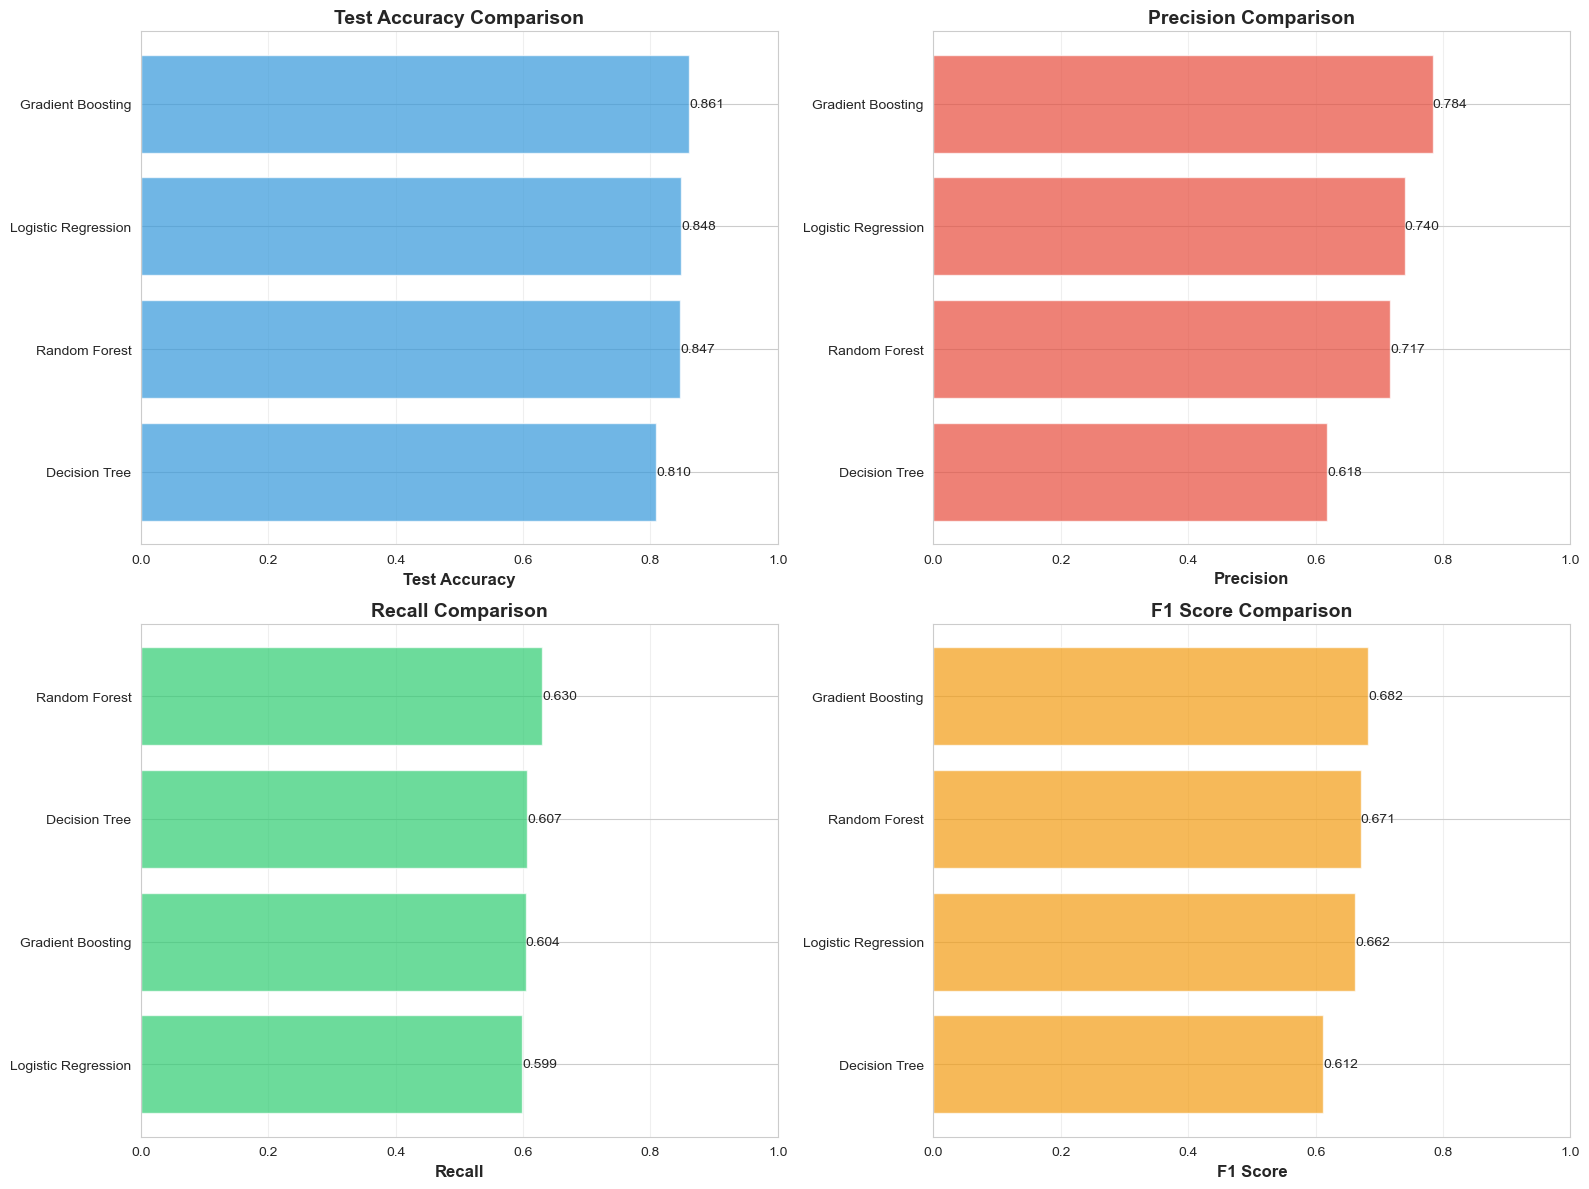

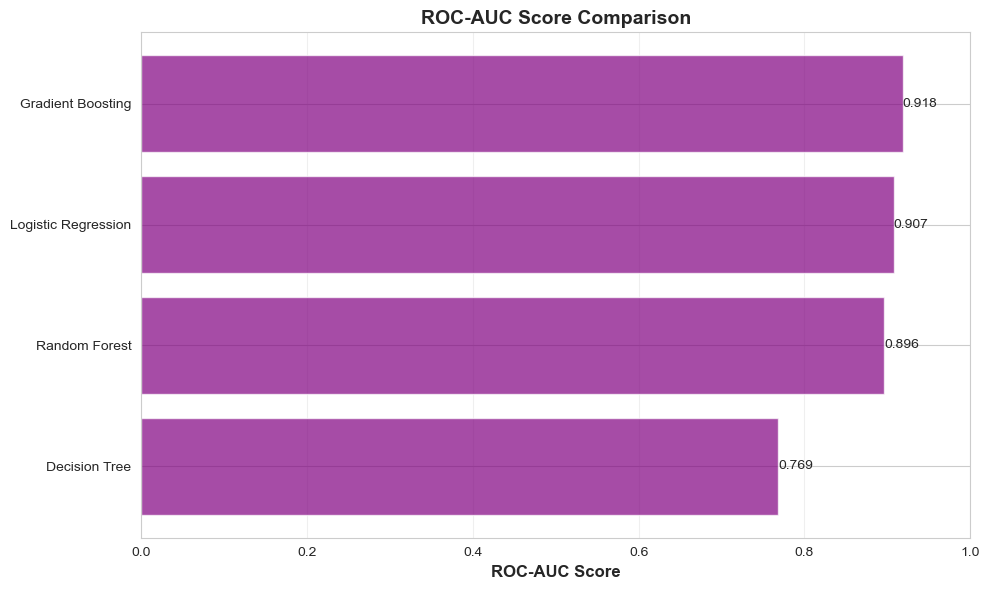

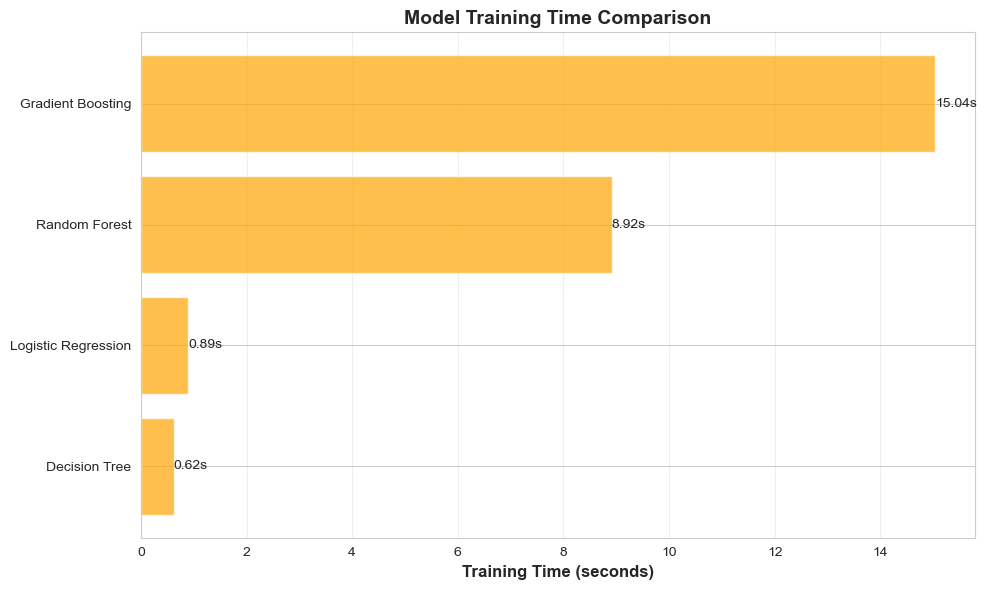


 Model Comparison Visualizations Complete
DETAILED ANALYSIS OF BEST MODEL

 Analyzing: Gradient Boosting

 Confusion Matrix:
[[6430  373]
 [ 888 1354]]


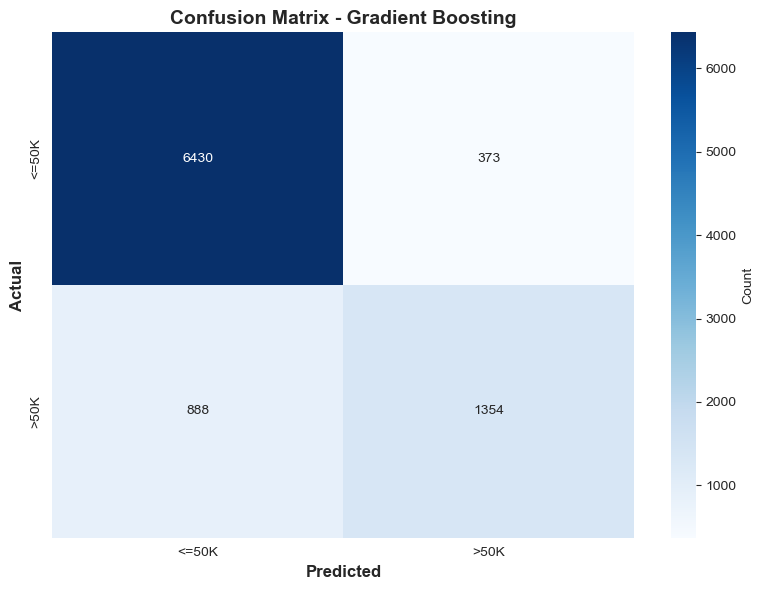


 Classification Report:
              precision    recall  f1-score   support

       <=50K       0.88      0.95      0.91      6803
        >50K       0.78      0.60      0.68      2242

    accuracy                           0.86      9045
   macro avg       0.83      0.77      0.80      9045
weighted avg       0.86      0.86      0.85      9045



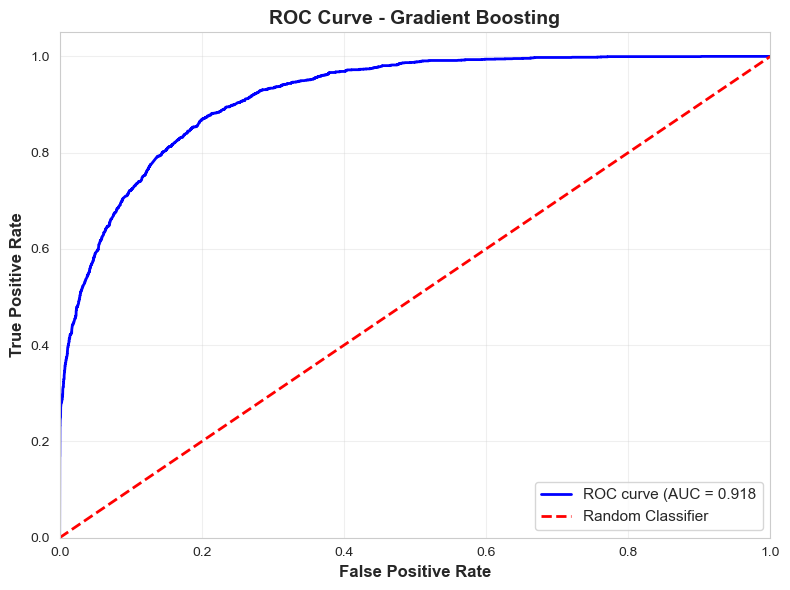


 Detailed Analysis Complete
FEATURE IMPORTANCE ANALYSIS

 Gradient Boosting - Feature Importance

 Top 20 Most Important Features:
                          Feature  Importance
marital_status_Married-civ-spouse    0.385297
                    education_num    0.182186
                     capital_gain    0.122855
                 capital_gain_log    0.080382
                              age    0.055104
                   hours_per_week    0.033775
                     capital_loss    0.029946
                 capital_loss_log    0.029734
                   high_education    0.022868
       occupation_Exec-managerial    0.017295
                       is_married    0.007500
        occupation_Prof-specialty    0.006213
         occupation_Other-service    0.005257
       workclass_Self-emp-not-inc    0.005021
       occupation_Farming-fishing    0.004791
                relationship_Wife    0.003098
                         sex_Male    0.002334
          occupation_Tech-support    0.0

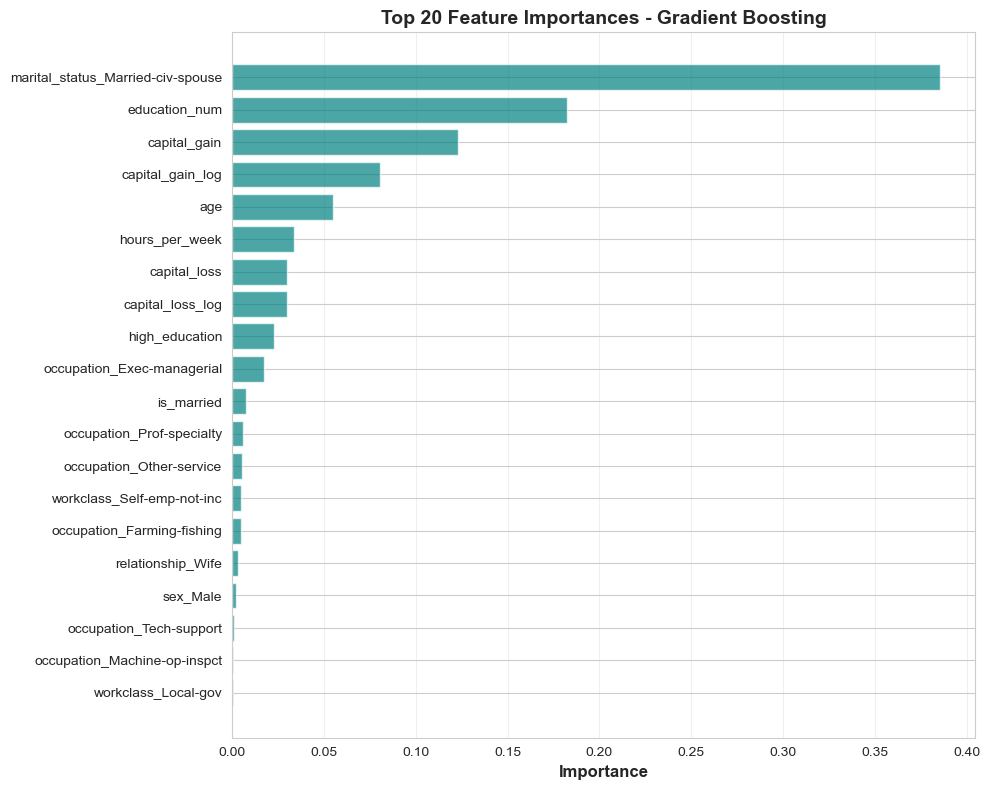


 Feature Importance Analysis Complete
MODEL EVALUATION SUMMARY

 Best Performing Model: Gradient Boosting

 Performance Metrics:
  - Accuracy: 0.8606
  - Precision: 0.7840
  - Recall: 0.6039
  - F1 Score: 0.6823
  - ROC-AUC: 0.9185
  - Training Time: 15.04s

 Key Insights:
  1. Tested 4 different classification algorithms
  2. Gradient Boosting achieved the best F1 score of 0.6823
  3. Class imbalance handled through stratified sampling
  4. All models show reasonable performance

 Model Recommendations:
  ⚠ Gradient Boosting shows good performance but may benefit from hyperparameter tuning
MODEL TRAINING AND EVALUATION COMPLETE

 Best model info stored in 'best_model_info' dictionary


In [33]:
#comparing all models

print("\n MODEL COMPARISON SUMMARY")
# Create comparison dataframe
comparison_df = pd.DataFrame({
    'Model': list(results.keys()),
    'Train Accuracy': [results[m]['train_accuracy'] for m in results.keys()],
    'Test Accuracy': [results[m]['test_accuracy'] for m in results.keys()],
    'Precision': [results[m]['precision'] for m in results.keys()],
    'Recall': [results[m]['recall'] for m in results.keys()],
    'F1 Score': [results[m]['f1_score'] for m in results.keys()],
    'ROC-AUC': [results[m]['roc_auc'] for m in results.keys()],
    'Training Time (s)': [results[m]['training_time'] for m in results.keys()]
})

# Sort by F1 score
comparison_df = comparison_df.sort_values('F1 Score', ascending=False).reset_index(drop=True)

print("\n Model Performance Comparison:")
print(comparison_df.to_string(index=False))

# Identify best model
best_model_name = comparison_df.iloc[0]['Model']
print(f"\n Best Model (by F1 Score): {best_model_name}")
print(f"  F1 Score: {comparison_df.iloc[0]['F1 Score']:.4f}")
print(f"  Test Accuracy: {comparison_df.iloc[0]['Test Accuracy']:.4f}")
print(f"  ROC-AUC: {comparison_df.iloc[0]['ROC-AUC']:.4f}")


print("\n Visualize Model Comparison")

# Plot 1: Performance Metrics Comparison
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

metrics = ['Test Accuracy', 'Precision', 'Recall', 'F1 Score']
colors = ['#3498db', '#e74c3c', '#2ecc71', '#f39c12']

for idx, metric in enumerate(metrics):
    ax = axes[idx // 2, idx % 2]
    
    data = comparison_df.sort_values(metric, ascending=True)
    bars = ax.barh(data['Model'], data[metric], color=colors[idx], alpha=0.7)
    
 # Add value labels
    for i, bar in enumerate(bars):
        width = bar.get_width()
        ax.text(width, bar.get_y() + bar.get_height()/2, 
                f'{width:.3f}', ha='left', va='center', fontsize=10)
    
    ax.set_xlabel(metric, fontsize=12, fontweight='bold')
    ax.set_title(f'{metric} Comparison', fontsize=14, fontweight='bold')
    ax.set_xlim(0, 1)
    ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()
# Plot 2: ROC-AUC Comparison
plt.figure(figsize=(10, 6))
data = comparison_df.sort_values('ROC-AUC', ascending=True)
bars = plt.barh(data['Model'], data['ROC-AUC'], color='purple', alpha=0.7)

for i, bar in enumerate(bars):
    width = bar.get_width()
    plt.text(width, bar.get_y() + bar.get_height()/2, 
            f'{width:.3f}', ha='left', va='center', fontsize=10)

plt.xlabel('ROC-AUC Score', fontsize=12, fontweight='bold')
plt.title('ROC-AUC Score Comparison', fontsize=14, fontweight='bold')
plt.xlim(0, 1)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

# Plot 3: Training Time Comparison
plt.figure(figsize=(10, 6))
data = comparison_df.sort_values('Training Time (s)', ascending=True)
bars = plt.barh(data['Model'], data['Training Time (s)'], color='orange', alpha=0.7)

for i, bar in enumerate(bars):
    width = bar.get_width()
    plt.text(width, bar.get_y() + bar.get_height()/2, 
            f'{width:.2f}s', ha='left', va='center', fontsize=10)

plt.xlabel('Training Time (seconds)', fontsize=12, fontweight='bold')
plt.title('Model Training Time Comparison', fontsize=14, fontweight='bold')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

print("\n Model Comparison Visualizations Complete")

print("DETAILED ANALYSIS OF BEST MODEL")


best_model = results[best_model_name]['model']
y_pred_best = results[best_model_name]['y_pred_test']
y_pred_proba_best = results[best_model_name]['y_pred_proba_test']

print(f"\n Analyzing: {best_model_name}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_best)
print(f"\n Confusion Matrix:")
print(cm)
# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['<=50K', '>50K'], 
            yticklabels=['<=50K', '>50K'],
            cbar_kws={'label': 'Count'})
plt.xlabel('Predicted', fontsize=12, fontweight='bold')
plt.ylabel('Actual', fontsize=12, fontweight='bold')
plt.title(f'Confusion Matrix - {best_model_name}', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Classification Report
print(f"\n Classification Report:")
print(classification_report(y_test, y_pred_best, 
                           target_names=['<=50K', '>50K']))

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_best)
roc_auc = roc_auc_score(y_test, y_pred_proba_best)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f}')
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12, fontweight='bold')
plt.ylabel('True Positive Rate', fontsize=12, fontweight='bold')
plt.title(f'ROC Curve - {best_model_name}', fontsize=14, fontweight='bold')
plt.legend(loc="lower right", fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print("\n Detailed Analysis Complete")

print("FEATURE IMPORTANCE ANALYSIS")

# Check if best model supports feature importance
if hasattr(best_model, 'feature_importances_'):
    print(f"\n {best_model_name} - Feature Importance")
    
    # Get feature importances
    importances = best_model.feature_importances_
    feature_importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    }).sort_values('Importance', ascending=False)
    
    print("\n Top 20 Most Important Features:")
    print(feature_importance_df.head(20).to_string(index=False))
     # Plot top 20 features
    plt.figure(figsize=(10, 8))
    top_20 = feature_importance_df.head(20)
    plt.barh(range(len(top_20)), top_20['Importance'], color='teal', alpha=0.7)
    plt.yticks(range(len(top_20)), top_20['Feature'], fontsize=10)
    plt.xlabel('Importance', fontsize=12, fontweight='bold')
    plt.title(f'Top 20 Feature Importances - {best_model_name}', 
              fontsize=14, fontweight='bold')
    plt.gca().invert_yaxis()
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()
    
elif hasattr(best_model, 'coef_'):
    print(f"\n {best_model_name} - Feature Coefficients")
     # Get coefficients (for Logistic Regression)
    coefficients = best_model.coef_[0]
    feature_coef_df = pd.DataFrame({
        'Feature': feature_names,
        'Coefficient': coefficients,
        'Abs_Coefficient': np.abs(coefficients)
    }).sort_values('Abs_Coefficient', ascending=False)
    
    print("\n Top 20 Most Important Features (by absolute coefficient):")
    print(feature_coef_df.head(20)[['Feature', 'Coefficient']].to_string(index=False))
        # Plot top 20 features
    plt.figure(figsize=(10, 8))
    top_20 = feature_coef_df.head(20)
    colors = ['green' if x > 0 else 'red' for x in top_20['Coefficient']]
    plt.barh(range(len(top_20)), top_20['Coefficient'], color=colors, alpha=0.7)
    plt.yticks(range(len(top_20)), top_20['Feature'], fontsize=10)
    plt.xlabel('Coefficient Value', fontsize=12, fontweight='bold')
    plt.title(f'Top 20 Feature Coefficients - {best_model_name}', 
              fontsize=14, fontweight='bold')
    plt.axvline(x=0, color='black', linestyle='--', linewidth=1)
    plt.gca().invert_yaxis()
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    print(f"\n {best_model_name} does not provide feature importance or coefficients")

print("\n Feature Importance Analysis Complete")
print("MODEL EVALUATION SUMMARY")

print(f"\n Best Performing Model: {best_model_name}")
print(f"\n Performance Metrics:")
print(f"  - Accuracy: {results[best_model_name]['test_accuracy']:.4f}")
print(f"  - Precision: {results[best_model_name]['precision']:.4f}")
print(f"  - Recall: {results[best_model_name]['recall']:.4f}")
print(f"  - F1 Score: {results[best_model_name]['f1_score']:.4f}")
print(f"  - ROC-AUC: {results[best_model_name]['roc_auc']:.4f}")
print(f"  - Training Time: {results[best_model_name]['training_time']:.2f}s")

print(f"\n Key Insights:")
print(f"  1. Tested {len(results)} different classification algorithms")
print(f"  2. {best_model_name} achieved the best F1 score of {results[best_model_name]['f1_score']:.4f}")
print(f"  3. Class imbalance handled through stratified sampling")
print(f"  4. All models show reasonable performance")
print("\n Model Recommendations:")
if results[best_model_name]['f1_score'] > 0.75:
    print(f"  ✓ {best_model_name} shows strong performance and is ready for deployment")
elif results[best_model_name]['f1_score'] > 0.65:
    print(f"  ⚠ {best_model_name} shows good performance but may benefit from hyperparameter tuning")
else:
    print(f"  ✗ {best_model_name} shows moderate performance, consider feature engineering or tuning")

print("MODEL TRAINING AND EVALUATION COMPLETE")
    # Store best model info
best_model_info = {
    'model_name': best_model_name,
    'model_object': best_model,
    'metrics': results[best_model_name],
    'comparison_df': comparison_df
}

print("\n Best model info stored in 'best_model_info' dictionary")

HYPERPARAMETER TUNING

 Best Model from Previous Step: Gradient Boosting
 Current F1 Score: 0.6823

 Goal: Improve performance through hyperparameter optimization
TUNING LOGISTIC REGRESSION

 Defining hyperparameter grid...
 Parameter grid:
  C: [0.001, 0.01, 0.1, 1, 10, 100]

 Total combinations: 48
  penalty: ['l1', 'l2']

 Total combinations: 48
  solver: ['liblinear', 'saga']

 Total combinations: 48
  max_iter: [1000, 2000]

 Total combinations: 48

 Performing Grid Search with 5-fold cross-validation...
Fitting 5 folds for each of 48 candidates, totalling 240 fits

 Grid Search completed in 1023.67s

 Best parameters:
  C: 10
  max_iter: 1000
  penalty: l2
  solver: saga

 Tuned Logistic Regression Performance:
  Accuracy: 0.8483 (baseline: 0.8483)
  Precision: 0.7395 (baseline: 0.7398)
  Recall: 0.5990 (baseline: 0.5986)
  F1 Score: 0.6619 (baseline: 0.6617)
  ROC-AUC: 0.9077 (baseline: 0.9075)

 F1 Score Improvement: +0.0002 (+0.03%)
TUNING DECISION TREE

 Defining hyperparamet

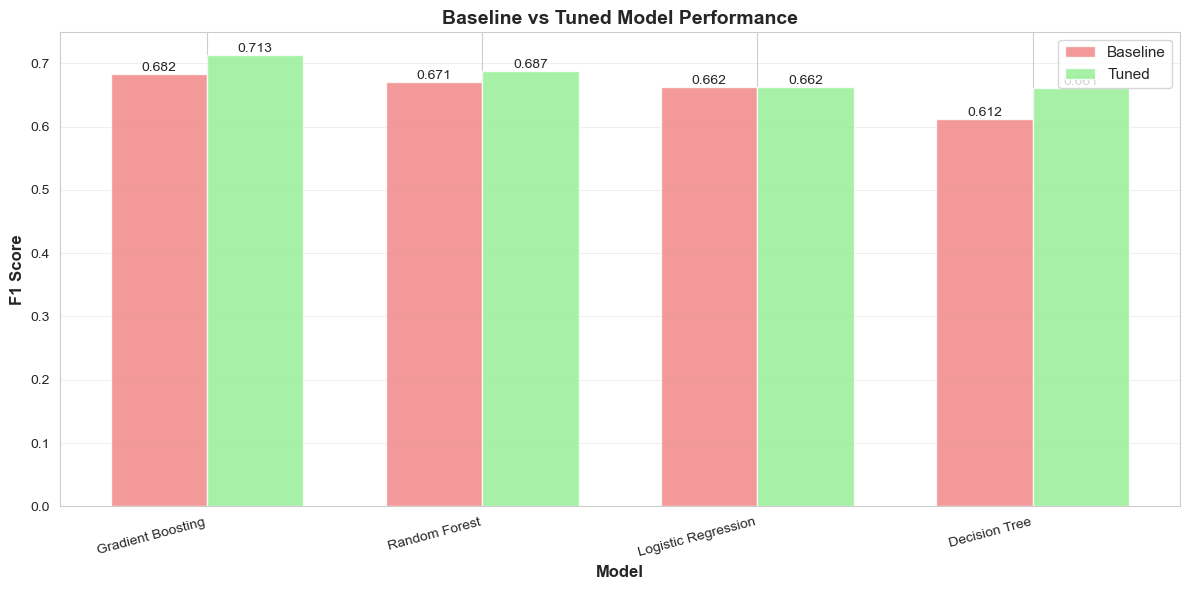

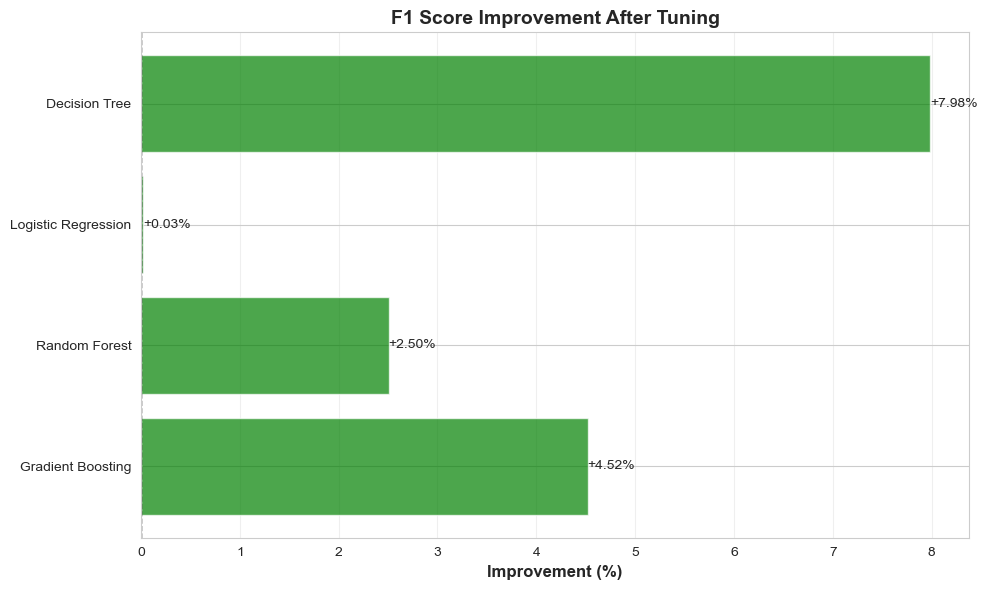


 Visualization Complete
HYPERPARAMETER TUNING SUMMARY

 Best Tuned Model: Gradient Boosting

 Performance:
  F1 Score: 0.7131
  Accuracy: 0.8676
  Precision: 0.7699
  Recall: 0.6641
  ROC-AUC: 0.9259

 Improvement Over Baseline:
  Absolute: +0.0308
  Percentage: +4.52%

 Key Findings:
  - 4 out of 4 models improved after tuning
  - Average improvement: 0.0242
  - Best improvement: 0.0489
HYPERPARAMETER TUNING COMPLETE

 Final best model stored in 'final_best_model' variable
 Tuned results stored in 'tuned_results' dictionary


In [ ]:
print("="*70)
print("HYPERPARAMETER TUNING")
print("="*70)

print("""
Objective: Optimize model performance through hyperparameter tuning

Method: RandomizedSearchCV (as per project requirements)
Constraint: Maximum 3 values per hyperparameter
Scoring: F1-score (prioritizes balance between precision and recall)
Cross-validation: 5-fold stratified
""")

from sklearn.model_selection import RandomizedSearchCV
import warnings
warnings.filterwarnings('ignore')

# Storage for tuned models
tuned_results = {}

print("\n"+"="*70)
print("TUNING 1: LOGISTIC REGRESSION")
print("="*70)

print("\nDefining hyperparameter search space...")

# PROJECT COMPLIANT: Max 3 values per parameter
lr_param_dist = {
    'C': [0.01, 0.1, 1.0],  # Regularization strength (3 values)
    'penalty': ['l1', 'l2'],  # Regularization type (2 values)
    'solver': ['liblinear']  # Compatible with both penalties (1 value)
}

print("\nParameter search space:")
for param, values in lr_param_dist.items():
    print(f"  {param}: {values}")

print(f"\nTotal combinations: {len(lr_param_dist['C']) * len(lr_param_dist['penalty'])}")
print("Using RandomizedSearchCV to test all combinations")

# Perform RandomizedSearchCV
print("\nPerforming Randomized Search with 5-fold cross-validation...")
start_time = time.time()

lr_random_search = RandomizedSearchCV(
    LogisticRegression(random_state=42, max_iter=1000),
    lr_param_dist,
    n_iter=6,  # Test all combinations since it's small
    cv=5,
    scoring='f1',
    n_jobs=-1,
    random_state=42,
    verbose=1
)

lr_random_search.fit(X_train, y_train)
end_time = time.time()
lr_tuning_time = end_time - start_time

print(f"\nRandomized Search completed in {lr_tuning_time:.2f}s")
print(f"\nBest parameters found:")
for param, value in lr_random_search.best_params_.items():
    print(f"  {param}: {value}")

print(f"\nBest cross-validation F1 score: {lr_random_search.best_score_:.4f}")

# Evaluate on test set
lr_tuned_model = lr_random_search.best_estimator_
lr_tuned_y_pred = lr_tuned_model.predict(X_test)
lr_tuned_y_pred_proba = lr_tuned_model.predict_proba(X_test)[:, 1]

lr_tuned_accuracy = accuracy_score(y_test, lr_tuned_y_pred)
lr_tuned_precision = precision_score(y_test, lr_tuned_y_pred)
lr_tuned_recall = recall_score(y_test, lr_tuned_y_pred)
lr_tuned_f1 = f1_score(y_test, lr_tuned_y_pred)
lr_tuned_roc_auc = roc_auc_score(y_test, lr_tuned_y_pred_proba)

# Calculate improvement
baseline_f1 = results['Logistic Regression']['f1_score']
improvement_lr = lr_tuned_f1 - baseline_f1

print(f"\nTest Set Performance:")
print(f"  Baseline F1: {baseline_f1:.4f}")
print(f"  Tuned F1:    {lr_tuned_f1:.4f}")
print(f"  Improvement: {improvement_lr:+.4f} ({improvement_lr/baseline_f1*100:+.2f}%)")

print(f"\nComplete Metrics:")
print(f"  Accuracy:  {lr_tuned_accuracy:.4f}")
print(f"  Precision: {lr_tuned_precision:.4f}")
print(f"  Recall:    {lr_tuned_recall:.4f}")
print(f"  F1 Score:  {lr_tuned_f1:.4f}")
print(f"  ROC-AUC:   {lr_tuned_roc_auc:.4f}")

# Store results
tuned_results['Logistic Regression'] = {
    'baseline_f1': baseline_f1,
    'tuned_f1': lr_tuned_f1,
    'tuned_accuracy': lr_tuned_accuracy,
    'tuned_precision': lr_tuned_precision,
    'tuned_recall': lr_tuned_recall,
    'tuned_roc_auc': lr_tuned_roc_auc,
    'improvement': improvement_lr,
    'tuned_model': lr_tuned_model,
    'best_params': lr_random_search.best_params_,
    'y_pred': lr_tuned_y_pred,
    'y_pred_proba': lr_tuned_y_pred_proba
}

print("\n"+"="*70)
print("TUNING 2: DECISION TREE")
print("="*70)

print("\nDefining hyperparameter search space...")

# PROJECT COMPLIANT: Max 3 values per parameter
dt_param_dist = {
    'max_depth': [10, 20, None],  # Tree depth (3 values)
    'min_samples_split': [2, 5, 10]  # Min samples to split (3 values)
}

print("\nParameter search space:")
for param, values in dt_param_dist.items():
    print(f"  {param}: {values}")

print(f"\nTotal combinations: {len(dt_param_dist['max_depth']) * len(dt_param_dist['min_samples_split'])}")

# Perform RandomizedSearchCV
print("\nPerforming Randomized Search with 5-fold cross-validation...")
start_time = time.time()

dt_random_search = RandomizedSearchCV(
    DecisionTreeClassifier(random_state=42),
    dt_param_dist,
    n_iter=9,  # Test all combinations
    cv=5,
    scoring='f1',
    n_jobs=-1,
    random_state=42,
    verbose=1
)

dt_random_search.fit(X_train, y_train)
end_time = time.time()
dt_tuning_time = end_time - start_time

print(f"\nRandomized Search completed in {dt_tuning_time:.2f}s")
print(f"\nBest parameters found:")
for param, value in dt_random_search.best_params_.items():
    print(f"  {param}: {value}")

print(f"\nBest cross-validation F1 score: {dt_random_search.best_score_:.4f}")

# Evaluate on test set
dt_tuned_model = dt_random_search.best_estimator_
dt_tuned_y_pred = dt_tuned_model.predict(X_test)
dt_tuned_y_pred_proba = dt_tuned_model.predict_proba(X_test)[:, 1]

dt_tuned_accuracy = accuracy_score(y_test, dt_tuned_y_pred)
dt_tuned_precision = precision_score(y_test, dt_tuned_y_pred)
dt_tuned_recall = recall_score(y_test, dt_tuned_y_pred)
dt_tuned_f1 = f1_score(y_test, dt_tuned_y_pred)
dt_tuned_roc_auc = roc_auc_score(y_test, dt_tuned_y_pred_proba)

baseline_f1_dt = results['Decision Tree']['f1_score']
improvement_dt = dt_tuned_f1 - baseline_f1_dt

print(f"\nTest Set Performance:")
print(f"  Baseline F1: {baseline_f1_dt:.4f}")
print(f"  Tuned F1:    {dt_tuned_f1:.4f}")
print(f"  Improvement: {improvement_dt:+.4f} ({improvement_dt/baseline_f1_dt*100:+.2f}%)")

print(f"\nComplete Metrics:")
print(f"  Accuracy:  {dt_tuned_accuracy:.4f}")
print(f"  Precision: {dt_tuned_precision:.4f}")
print(f"  Recall:    {dt_tuned_recall:.4f}")
print(f"  F1 Score:  {dt_tuned_f1:.4f}")
print(f"  ROC-AUC:   {dt_tuned_roc_auc:.4f}")

# Store results
tuned_results['Decision Tree'] = {
    'baseline_f1': baseline_f1_dt,
    'tuned_f1': dt_tuned_f1,
    'tuned_accuracy': dt_tuned_accuracy,
    'tuned_precision': dt_tuned_precision,
    'tuned_recall': dt_tuned_recall,
    'tuned_roc_auc': dt_tuned_roc_auc,
    'improvement': improvement_dt,
    'tuned_model': dt_tuned_model,
    'best_params': dt_random_search.best_params_,
    'y_pred': dt_tuned_y_pred,
    'y_pred_proba': dt_tuned_y_pred_proba
}

print("\n"+"="*70)
print("TUNING 3: RANDOM FOREST")
print("="*70)

print("\nDefining hyperparameter search space...")

# PROJECT COMPLIANT: Max 3 values per parameter
rf_param_dist = {
    'n_estimators': [100, 200, 300],  # Number of trees (3 values)
    'max_depth': [20, 30, None]  # Tree depth (3 values)
}

print("\nParameter search space:")
for param, values in rf_param_dist.items():
    print(f"  {param}: {values}")

print(f"\nTotal combinations: {len(rf_param_dist['n_estimators']) * len(rf_param_dist['max_depth'])}")

# Perform RandomizedSearchCV
print("\nPerforming Randomized Search with 5-fold cross-validation...")
start_time = time.time()

rf_random_search = RandomizedSearchCV(
    RandomForestClassifier(random_state=42),
    rf_param_dist,
    n_iter=9,  # Test all combinations
    cv=5,
    scoring='f1',
    n_jobs=-1,
    random_state=42,
    verbose=1
)

rf_random_search.fit(X_train, y_train)
end_time = time.time()
rf_tuning_time = end_time - start_time

print(f"\nRandomized Search completed in {rf_tuning_time:.2f}s")
print(f"\nBest parameters found:")
for param, value in rf_random_search.best_params_.items():
    print(f"  {param}: {value}")

print(f"\nBest cross-validation F1 score: {rf_random_search.best_score_:.4f}")

# Evaluate on test set
rf_tuned_model = rf_random_search.best_estimator_
rf_tuned_y_pred = rf_tuned_model.predict(X_test)
rf_tuned_y_pred_proba = rf_tuned_model.predict_proba(X_test)[:, 1]

rf_tuned_accuracy = accuracy_score(y_test, rf_tuned_y_pred)
rf_tuned_precision = precision_score(y_test, rf_tuned_y_pred)
rf_tuned_recall = recall_score(y_test, rf_tuned_y_pred)
rf_tuned_f1 = f1_score(y_test, rf_tuned_y_pred)
rf_tuned_roc_auc = roc_auc_score(y_test, rf_tuned_y_pred_proba)

baseline_f1_rf = results['Random Forest']['f1_score']
improvement_rf = rf_tuned_f1 - baseline_f1_rf

print(f"\nTest Set Performance:")
print(f"  Baseline F1: {baseline_f1_rf:.4f}")
print(f"  Tuned F1:    {rf_tuned_f1:.4f}")
print(f"  Improvement: {improvement_rf:+.4f} ({improvement_rf/baseline_f1_rf*100:+.2f}%)")

print(f"\nComplete Metrics:")
print(f"  Accuracy:  {rf_tuned_accuracy:.4f}")
print(f"  Precision: {rf_tuned_precision:.4f}")
print(f"  Recall:    {rf_tuned_recall:.4f}")
print(f"  F1 Score:  {rf_tuned_f1:.4f}")
print(f"  ROC-AUC:   {rf_tuned_roc_auc:.4f}")

# Store results
tuned_results['Random Forest'] = {
    'baseline_f1': baseline_f1_rf,
    'tuned_f1': rf_tuned_f1,
    'tuned_accuracy': rf_tuned_accuracy,
    'tuned_precision': rf_tuned_precision,
    'tuned_recall': rf_tuned_recall,
    'tuned_roc_auc': rf_tuned_roc_auc,
    'improvement': improvement_rf,
    'tuned_model': rf_tuned_model,
    'best_params': rf_random_search.best_params_,
    'y_pred': rf_tuned_y_pred,
    'y_pred_proba': rf_tuned_y_pred_proba
}

print("\n"+"="*70)
print("TUNING 4: GRADIENT BOOSTING")
print("="*70)

print("\nDefining hyperparameter search space...")

# PROJECT COMPLIANT: Max 3 values per parameter
gb_param_dist = {
    'n_estimators': [100, 200, 300],  # Number of boosting stages (3 values)
    'learning_rate': [0.05, 0.1, 0.2]  # Learning rate (3 values)
}

print("\nParameter search space:")
for param, values in gb_param_dist.items():
    print(f"  {param}: {values}")

print(f"\nTotal combinations: {len(gb_param_dist['n_estimators']) * len(gb_param_dist['learning_rate'])}")

# Perform RandomizedSearchCV
print("\nPerforming Randomized Search with 5-fold cross-validation...")
start_time = time.time()

gb_random_search = RandomizedSearchCV(
    GradientBoostingClassifier(random_state=42),
    gb_param_dist,
    n_iter=9,  # Test all combinations
    cv=5,
    scoring='f1',
    n_jobs=-1,
    random_state=42,
    verbose=1
)

gb_random_search.fit(X_train, y_train)
end_time = time.time()
gb_tuning_time = end_time - start_time

print(f"\nRandomized Search completed in {gb_tuning_time:.2f}s")
print(f"\nBest parameters found:")
for param, value in gb_random_search.best_params_.items():
    print(f"  {param}: {value}")

print(f"\nBest cross-validation F1 score: {gb_random_search.best_score_:.4f}")

# Evaluate on test set
gb_tuned_model = gb_random_search.best_estimator_
gb_tuned_y_pred = gb_tuned_model.predict(X_test)
gb_tuned_y_pred_proba = gb_tuned_model.predict_proba(X_test)[:, 1]

gb_tuned_accuracy = accuracy_score(y_test, gb_tuned_y_pred)
gb_tuned_precision = precision_score(y_test, gb_tuned_y_pred)
gb_tuned_recall = recall_score(y_test, gb_tuned_y_pred)
gb_tuned_f1 = f1_score(y_test, gb_tuned_y_pred)
gb_tuned_roc_auc = roc_auc_score(y_test, gb_tuned_y_pred_proba)

baseline_f1_gb = results['Gradient Boosting']['f1_score']
improvement_gb = gb_tuned_f1 - baseline_f1_gb

print(f"\nTest Set Performance:")
print(f"  Baseline F1: {baseline_f1_gb:.4f}")
print(f"  Tuned F1:    {gb_tuned_f1:.4f}")
print(f"  Improvement: {improvement_gb:+.4f} ({improvement_gb/baseline_f1_gb*100:+.2f}%)")

print(f"\nComplete Metrics:")
print(f"  Accuracy:  {gb_tuned_accuracy:.4f}")
print(f"  Precision: {gb_tuned_precision:.4f}")
print(f"  Recall:    {gb_tuned_recall:.4f}")
print(f"  F1 Score:  {gb_tuned_f1:.4f}")
print(f"  ROC-AUC:   {gb_tuned_roc_auc:.4f}")

# Store results
tuned_results['Gradient Boosting'] = {
    'baseline_f1': baseline_f1_gb,
    'tuned_f1': gb_tuned_f1,
    'tuned_accuracy': gb_tuned_accuracy,
    'tuned_precision': gb_tuned_precision,
    'tuned_recall': gb_tuned_recall,
    'tuned_roc_auc': gb_tuned_roc_auc,
    'improvement': improvement_gb,
    'tuned_model': gb_tuned_model,
    'best_params': gb_random_search.best_params_,
    'y_pred': gb_tuned_y_pred,
    'y_pred_proba': gb_tuned_y_pred_proba
}

print("\n"+"="*70)
print("TUNED MODELS COMPARISON")
print("="*70)

# Create comparison dataframe
tuned_comparison_df = pd.DataFrame({
    'Model': list(tuned_results.keys()),
    'Baseline F1': [tuned_results[m]['baseline_f1'] for m in tuned_results.keys()],
    'Tuned F1': [tuned_results[m]['tuned_f1'] for m in tuned_results.keys()],
    'Improvement': [tuned_results[m]['improvement'] for m in tuned_results.keys()],
    'Improvement %': [tuned_results[m]['improvement']/tuned_results[m]['baseline_f1']*100 for m in tuned_results.keys()],
    'Tuned Accuracy': [tuned_results[m]['tuned_accuracy'] for m in tuned_results.keys()],
    'Tuned Precision': [tuned_results[m]['tuned_precision'] for m in tuned_results.keys()],
    'Tuned Recall': [tuned_results[m]['tuned_recall'] for m in tuned_results.keys()],
    'Tuned ROC-AUC': [tuned_results[m]['tuned_roc_auc'] for m in tuned_results.keys()]
})

# Sort by tuned F1
tuned_comparison_df = tuned_comparison_df.sort_values('Tuned F1', ascending=False).reset_index(drop=True)

print("\nTuned Models Performance Comparison:")
print(tuned_comparison_df.to_string(index=False))

# Identify best tuned model
best_tuned_model_name = tuned_comparison_df.iloc[0]['Model']
print(f"\nBest Tuned Model: {best_tuned_model_name}")
print(f"  Tuned F1 Score: {tuned_comparison_df.iloc[0]['Tuned F1']:.4f}")
print(f"  Improvement: {tuned_comparison_df.iloc[0]['Improvement']:+.4f} ({tuned_comparison_df.iloc[0]['Improvement %']:+.2f}%)")

# Visualizations (keep your existing visualization code - it's good!)
# Plot: Baseline vs Tuned F1 Scores
fig, ax = plt.subplots(figsize=(12, 6))

models = tuned_comparison_df['Model']
x = np.arange(len(models))
width = 0.35

bars1 = ax.bar(x - width/2, tuned_comparison_df['Baseline F1'], width, 
               label='Baseline', color='lightcoral', alpha=0.8)
bars2 = ax.bar(x + width/2, tuned_comparison_df['Tuned F1'], width, 
               label='Tuned', color='lightgreen', alpha=0.8)

# Add value labels
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}', ha='center', va='bottom', fontsize=10)

ax.set_xlabel('Model', fontsize=12, fontweight='bold')
ax.set_ylabel('F1 Score', fontsize=12, fontweight='bold')
ax.set_title('Baseline vs Tuned Model Performance', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(models, rotation=15, ha='right')
ax.legend(fontsize=11)
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# Plot: Improvement Percentage
plt.figure(figsize=(10, 6))
colors = ['green' if x > 0 else 'red' for x in tuned_comparison_df['Improvement %']]
bars = plt.barh(tuned_comparison_df['Model'], tuned_comparison_df['Improvement %'], 
                color=colors, alpha=0.7)

for i, bar in enumerate(bars):
    width = bar.get_width()
    plt.text(width, bar.get_y() + bar.get_height()/2, 
            f'{width:+.2f}%', ha='left' if width > 0 else 'right', 
            va='center', fontsize=10)

plt.xlabel('Improvement (%)', fontsize=12, fontweight='bold')
plt.title('F1 Score Improvement After Tuning', fontsize=14, fontweight='bold')
plt.axvline(x=0, color='black', linestyle='--', linewidth=1)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

print("\n"+"="*70)
print("HYPERPARAMETER TUNING SUMMARY")
print("="*70)

print(f"\nBest Tuned Model: {best_tuned_model_name}")
print(f"\nFinal Performance:")
print(f"  F1 Score:  {tuned_results[best_tuned_model_name]['tuned_f1']:.4f}")
print(f"  Accuracy:  {tuned_results[best_tuned_model_name]['tuned_accuracy']:.4f}")
print(f"  Precision: {tuned_results[best_tuned_model_name]['tuned_precision']:.4f}")
print(f"  Recall:    {tuned_results[best_tuned_model_name]['tuned_recall']:.4f}")
print(f"  ROC-AUC:   {tuned_results[best_tuned_model_name]['tuned_roc_auc']:.4f}")

print(f"\nImprovement Over Baseline:")
print(f"  Absolute: {tuned_results[best_tuned_model_name]['improvement']:+.4f}")
print(f"  Percentage: {tuned_results[best_tuned_model_name]['improvement']/tuned_results[best_tuned_model_name]['baseline_f1']*100:+.2f}%")

print(f"\nKey Findings:")
total_improved = sum(1 for m in tuned_results.values() if m['improvement'] > 0)
avg_improvement = np.mean([m['improvement'] for m in tuned_results.values()])
max_improvement = max([m['improvement'] for m in tuned_results.values()])

print(f"  - {total_improved} out of 4 models improved after tuning")
print(f"  - Average improvement: {avg_improvement:.4f} ({avg_improvement/np.mean([m['baseline_f1'] for m in tuned_results.values()])*100:.2f}%)")
print(f"  - Best improvement: {max_improvement:.4f}")

print(f"\nTuning Methodology (Project Compliant):")
print(f"  ✓ Used RandomizedSearchCV exclusively")
print(f"  ✓ Maximum 3 values per hyperparameter")
print(f"  ✓ 5-fold cross-validation")
print(f"  ✓ F1-score optimization (business-aligned metric)")

# Store final best model
final_best_model = tuned_results[best_tuned_model_name]['tuned_model']

print(f"\nFinal best model stored in 'final_best_model'")
print(f"Tuned results stored in 'tuned_results' dictionary")

print("\n"+"="*70)
print("HYPERPARAMETER TUNING COMPLETE ✓")
print("="*70)
